# Data Visualization

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, random

X_TRAIN_DIR = Path(r"..\data\X_train_uDRk9z9")
X_TEST_DIR  = Path(r"..\data\X_train_uDRk9z9")
X_UNLAB_DIR = Path(r"..\data\X_unlabeled_mtkxUlo")
Y_TRAIN_CSV = Path(r"..\data\Y_train_T9NrBYo.csv")

def list_some(dir_path: Path, k=10):
    files = sorted(list(dir_path.rglob("*.npy")))
    if len(files) == 0:
        files = sorted(list(dir_path.rglob("*.NPY")))
    print(dir_path)
    print("n_files =", len(files))
    print("first few names:")
    for p in files[:k]:
        print(" ", p.name)
    return files

train_files = list_some(X_TRAIN_DIR, k=8)
test_files  = list_some(X_TEST_DIR,  k=8)
unlab_files = list_some(X_UNLAB_DIR, k=8)


..\data\X_train_uDRk9z9
n_files = 4410
first few names:
  well_1_section_0_patch_0.npy
  well_1_section_0_patch_1.npy
  well_1_section_0_patch_10.npy
  well_1_section_0_patch_11.npy
  well_1_section_0_patch_12.npy
  well_1_section_0_patch_13.npy
  well_1_section_0_patch_14.npy
  well_1_section_0_patch_15.npy
..\data\X_train_uDRk9z9
n_files = 4410
first few names:
  well_1_section_0_patch_0.npy
  well_1_section_0_patch_1.npy
  well_1_section_0_patch_10.npy
  well_1_section_0_patch_11.npy
  well_1_section_0_patch_12.npy
  well_1_section_0_patch_13.npy
  well_1_section_0_patch_14.npy
  well_1_section_0_patch_15.npy
..\data\X_unlabeled_mtkxUlo
n_files = 1980
first few names:
  well_12_section_10_patch_0.npy
  well_12_section_10_patch_1.npy
  well_12_section_10_patch_10.npy
  well_12_section_10_patch_11.npy
  well_12_section_10_patch_2.npy
  well_12_section_10_patch_3.npy
  well_12_section_10_patch_4.npy
  well_12_section_10_patch_5.npy


In [ ]:
def inspect_one_npy(path: Path):
    x = np.load(path)
    if x.ndim == 3 and x.shape[0] == 1:
        x = x[0]
    print("file:", path.name)
    print("shape:", x.shape, "dtype:", x.dtype)
    print("has_nan:", np.isnan(x).any(), "has_inf:", np.isinf(x).any())
    x0 = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    print("min/max/mean/std:", float(x0.min()), float(x0.max()), float(x0.mean()), float(x0.std()))
    return x0

for p in train_files[:3]:
    _ = inspect_one_npy(p)
    print("-"*60)


file: well_1_section_0_patch_0.npy
shape: (160, 272) dtype: int16
has_nan: False has_inf: False
min/max/mean/std: -330.0 345.0 0.060822610294117646 36.19590855351595
------------------------------------------------------------
file: well_1_section_0_patch_1.npy
shape: (160, 272) dtype: int16
has_nan: False has_inf: False
min/max/mean/std: -189.0 192.0 -0.02741268382352941 26.921422071942036
------------------------------------------------------------
file: well_1_section_0_patch_10.npy
shape: (160, 272) dtype: int16
has_nan: False has_inf: False
min/max/mean/std: -246.0 184.0 0.07722886029411764 26.7090272702919
------------------------------------------------------------


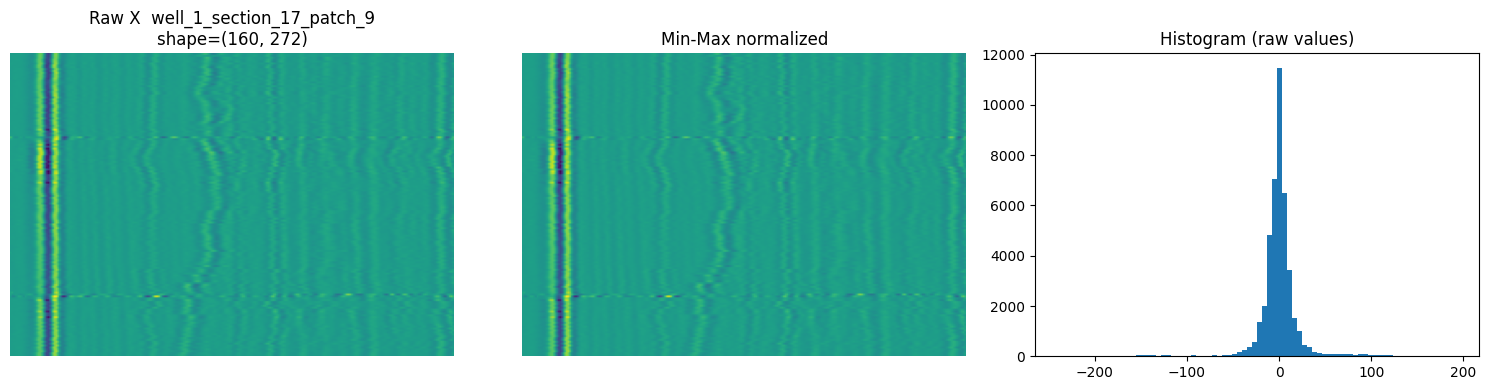

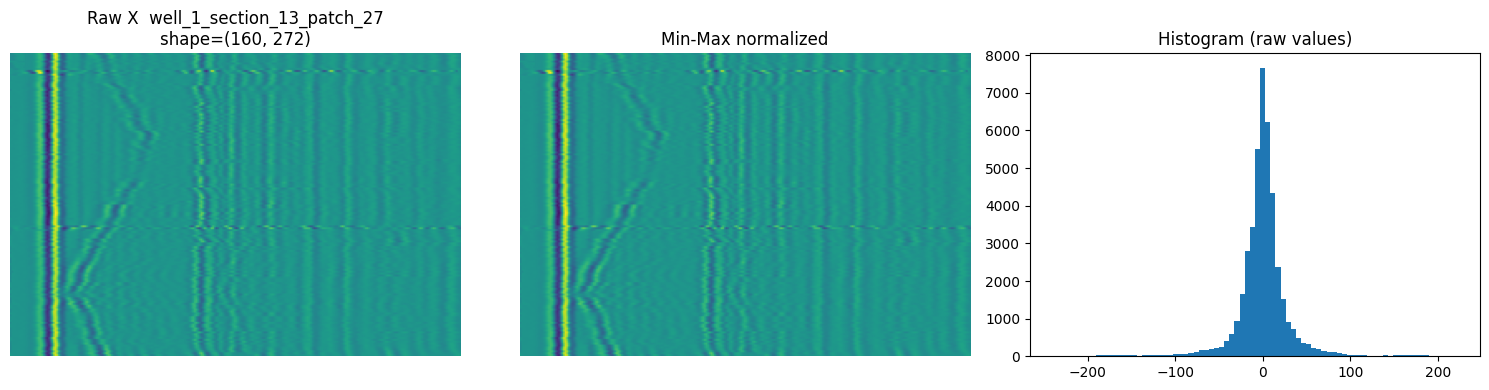

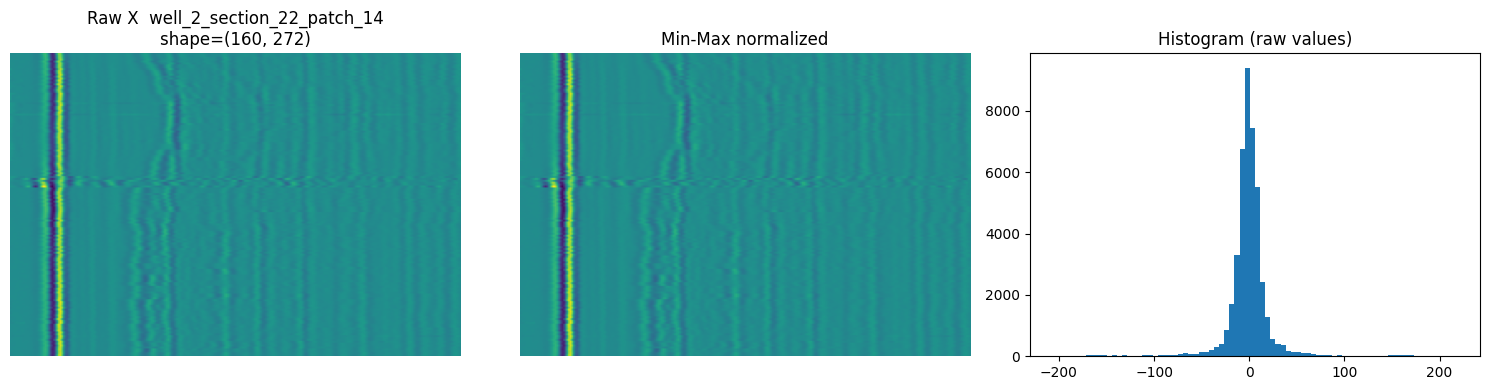

In [ ]:
def minmax_norm(x: np.ndarray) -> np.ndarray:
    mn, mx = float(x.min()), float(x.max())
    if mx > mn:
        return (x - mn) / (mx - mn)
    return np.zeros_like(x, dtype=np.float32)

def show_x(path: Path):
    x = np.load(path)
    if x.ndim == 3 and x.shape[0] == 1:
        x = x[0]
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    xn = minmax_norm(x)

    plt.figure(figsize=(15, 4))
    plt.subplot(1,3,1)
    plt.title(f"Raw X  {path.stem}\nshape={x.shape}")
    plt.imshow(x, aspect="auto")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Min-Max normalized")
    plt.imshow(xn, aspect="auto")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Histogram (raw values)")
    plt.hist(x.flatten(), bins=80)
    plt.tight_layout()
    plt.show()

for p in random.sample(train_files, k=3):
    show_x(p)


y_df shape: (4410, 43520)
index example: well_2_section_22_patch_1


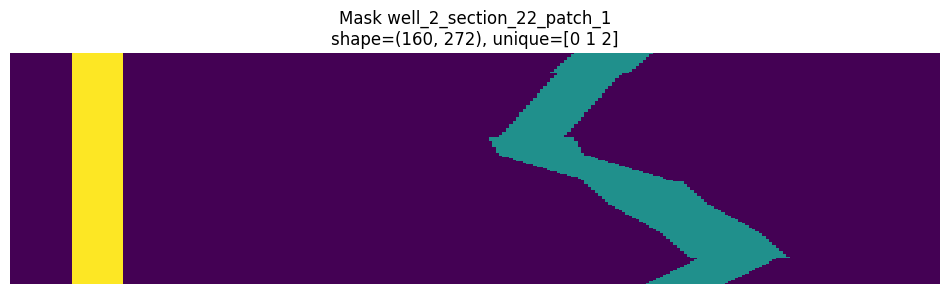

In [ ]:
y_df = pd.read_csv(Y_TRAIN_CSV, index_col=0)
print("y_df shape:", y_df.shape)
print("index example:", y_df.index[0])

def restore_mask_from_row(row_values: np.ndarray) -> np.ndarray:
    vals = row_values[row_values != -1]  # 去 padding
    mask = vals.reshape(160, -1)
    return mask.astype(np.int64)

def show_mask(name: str):
    row = y_df.loc[name].values
    m = restore_mask_from_row(row)
    plt.figure(figsize=(12, 3))
    plt.title(f"Mask {name}\nshape={m.shape}, unique={np.unique(m)}")
    plt.imshow(m, aspect="auto", interpolation="nearest")
    plt.axis("off")
    plt.show()
    return m

example_name = y_df.index[0]
_ = show_mask(example_name)


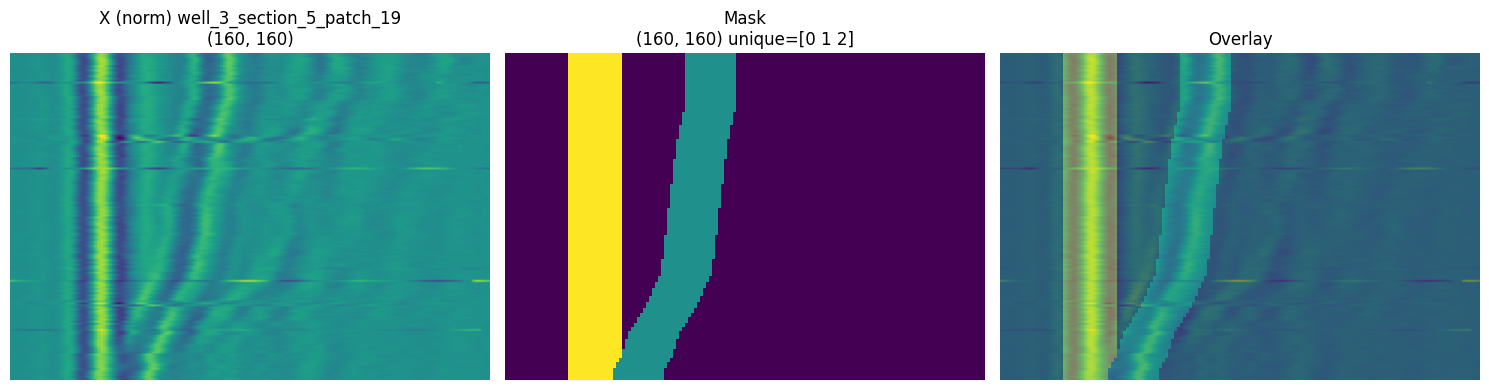

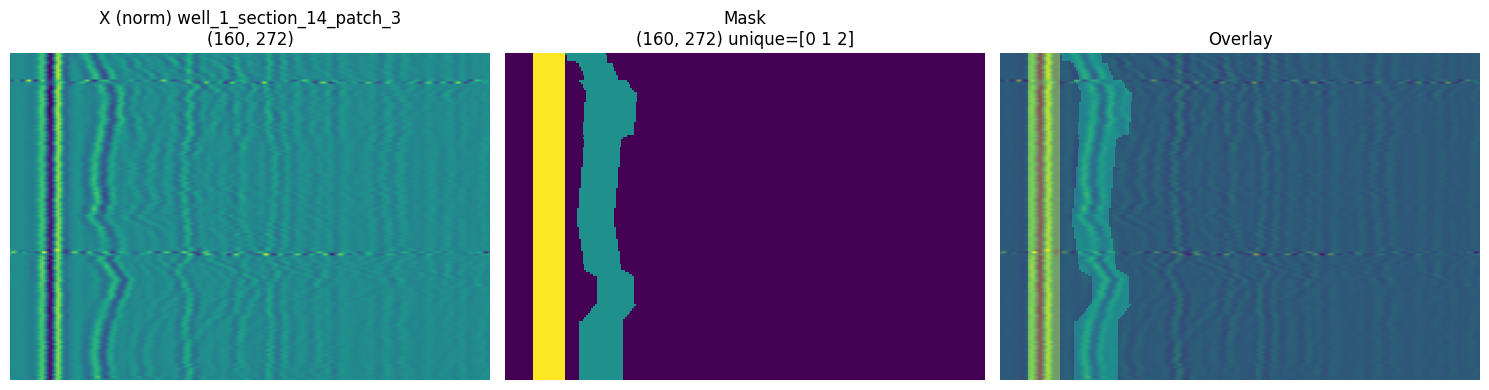

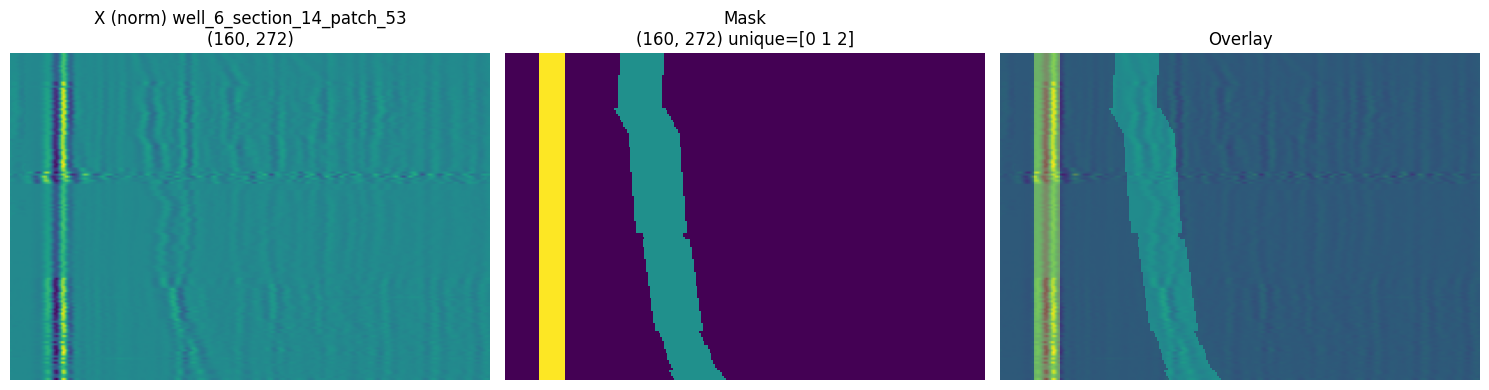

In [ ]:
def show_overlay(name: str):
    x_path = X_TRAIN_DIR / f"{name}.npy"
    if not x_path.exists():
        
        matches = list(X_TRAIN_DIR.rglob(f"{name}.npy"))
        if len(matches) == 0:
            matches = list(X_TRAIN_DIR.rglob(f"{name}.NPY"))
        if len(matches) == 0:
            raise FileNotFoundError(f"Cannot find {name}.npy under X_TRAIN_DIR")
        x_path = matches[0]

    x = np.load(x_path)
    if x.ndim == 3 and x.shape[0] == 1:
        x = x[0]
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    xn = minmax_norm(x)

    m = restore_mask_from_row(y_df.loc[name].values)

    plt.figure(figsize=(15, 4))
    plt.subplot(1,3,1)
    plt.title(f"X (norm) {name}\n{x.shape}")
    plt.imshow(xn, aspect="auto")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title(f"Mask\n{m.shape} unique={np.unique(m)}")
    plt.imshow(m, aspect="auto", interpolation="nearest")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Overlay")
    plt.imshow(xn, aspect="auto")
    plt.imshow(m, alpha=0.35, aspect="auto", interpolation="nearest")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

for name in random.sample(list(y_df.index), k=3):
    show_overlay(name)


found in first 2000 labels -> 160: 328  272: 1672


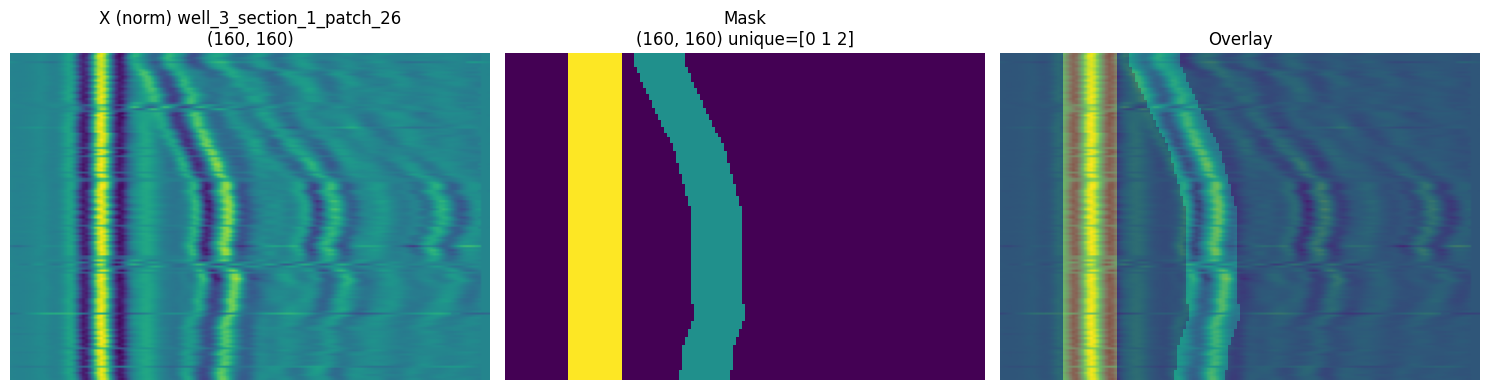

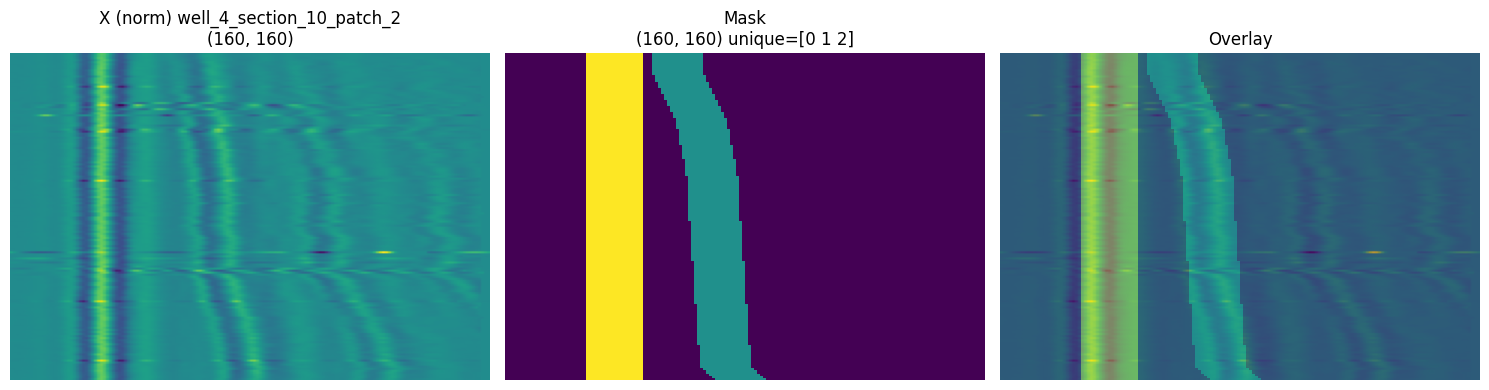

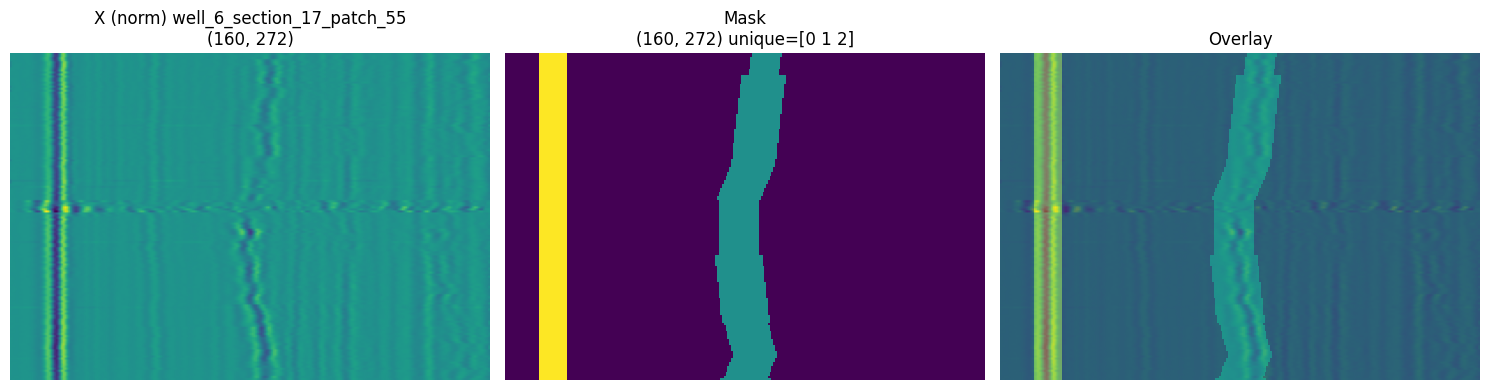

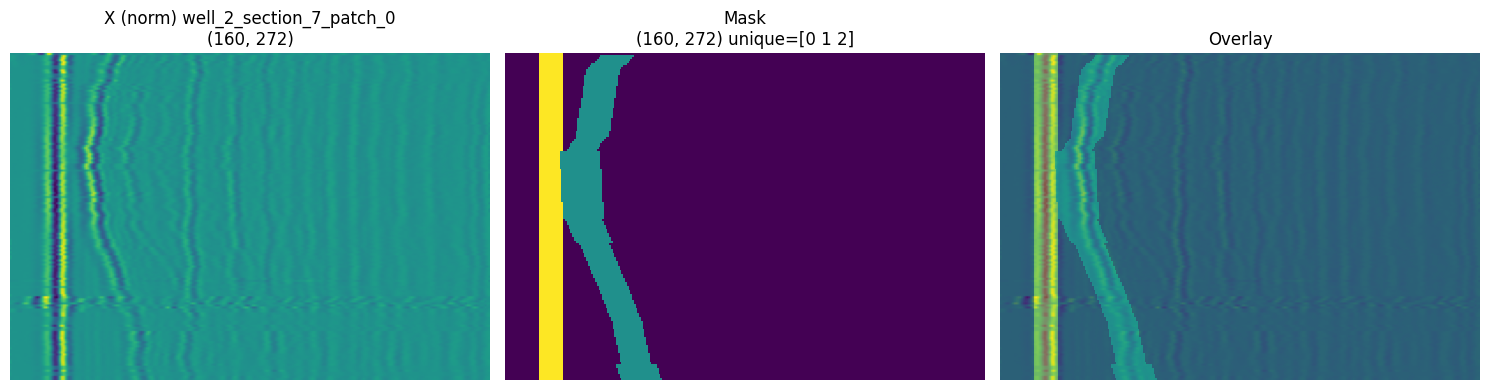

In [ ]:
def mask_width(name: str) -> int:
    m = restore_mask_from_row(y_df.loc[name].values)
    return int(m.shape[1])

names_160 = [n for n in y_df.index[:2000] if mask_width(n) == 160]
names_272 = [n for n in y_df.index[:2000] if mask_width(n) == 272]

print("found in first 2000 labels -> 160:", len(names_160), " 272:", len(names_272))

if len(names_160) > 0:
    for n in random.sample(names_160, k=min(2, len(names_160))):
        show_overlay(n)

if len(names_272) > 0:
    for n in random.sample(names_272, k=min(2, len(names_272))):
        show_overlay(n)


In [ ]:
from collections import Counter
import numpy as np
import pandas as pd

def restore_mask_from_row(row_values: np.ndarray) -> np.ndarray:
    vals = row_values[row_values != -1]
    return vals.reshape(160, -1).astype(np.int64)

width_counter = Counter()
for name, row in y_df.iterrows():
    m = restore_mask_from_row(row.values)
    width_counter[m.shape[1]] += 1

width_counter


Counter({272: 3726, 160: 684})

In [ ]:
from collections import defaultdict

pixel_counts = defaultdict(int)     # label -> total pixels
presence_counts = defaultdict(int)  # label -> number of patches where label appears
n_patches = 0

for name, row in y_df.iterrows():
    m = restore_mask_from_row(row.values)
    n_patches += 1
    uniq = np.unique(m)
    for v in uniq:
        presence_counts[int(v)] += 1
    for v, c in zip(*np.unique(m, return_counts=True)):
        pixel_counts[int(v)] += int(c)

total_pixels = sum(pixel_counts.values())
stats = []
for k in sorted(pixel_counts.keys()):
    stats.append({
        "label": k,
        "total_pixels": pixel_counts[k],
        "pixel_ratio": pixel_counts[k] / total_pixels,
        "patch_presence": presence_counts[k],
        "presence_ratio": presence_counts[k] / n_patches
    })

class_stats_df = pd.DataFrame(stats).sort_values("label").reset_index(drop=True)
class_stats_df


,label,total_pixels,pixel_ratio,patch_presence,presence_ratio
0,0,153256840,0.853010,4410,1.000000
1,1,15970360,0.088889,4362,0.989116
2,2,10438720,0.058101,4410,1.000000


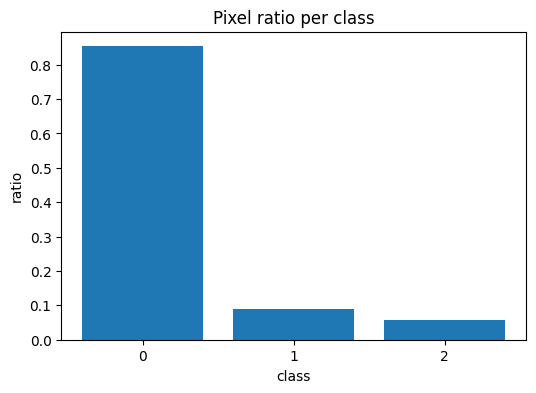

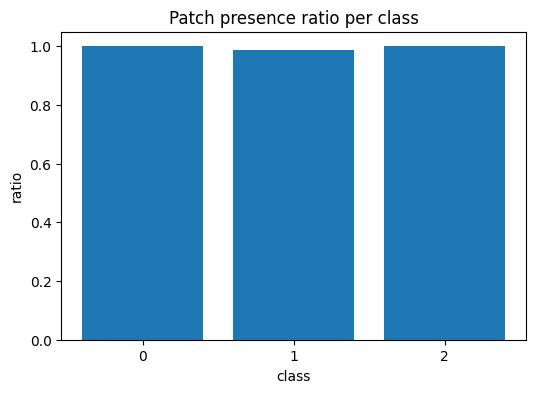

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(class_stats_df["label"].astype(str), class_stats_df["pixel_ratio"])
plt.title("Pixel ratio per class")
plt.xlabel("class")
plt.ylabel("ratio")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(class_stats_df["label"].astype(str), class_stats_df["presence_ratio"])
plt.title("Patch presence ratio per class")
plt.xlabel("class")
plt.ylabel("ratio")
plt.show()


In [ ]:
def parse_well(name: str) -> int:
    # name like well_2_section_22_patch_1
    return int(name.split("_")[1])

well_counter = defaultdict(int)
well_width_counter = defaultdict(lambda: defaultdict(int))

for name in y_df.index:
    w = restore_mask_from_row(y_df.loc[name].values).shape[1]
    well = parse_well(name)
    well_counter[well] += 1
    well_width_counter[well][w] += 1

well_rows = []
for well in sorted(well_counter.keys()):
    wd = dict(well_width_counter[well])
    well_rows.append({
        "well": well,
        "n_patches": well_counter[well],
        "n_w160": wd.get(160, 0),
        "n_w272": wd.get(272, 0),
    })

pd.DataFrame(well_rows).sort_values("well")


,well,n_patches,n_w160,n_w272
0,1,666,0,666
1,2,1152,0,1152
2,3,486,486,0
3,4,198,198,0
4,5,288,0,288
5,6,1620,0,1620


# SegNet

Main program
(Many of the comments here are in Chinese, so I used Chatgpt to translate them into English.)

In [ ]:
import re
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from functools import partial

# -----------------------
# split utils (by well)
# -----------------------
_WELL_RE = re.compile(r"^well_(\d+)_section_(\d+)_patch_(\d+)$")

def parse_patch_id(patch_id: str) -> tuple[int, int, int]:
    m = _WELL_RE.match(patch_id)
    if not m:
        raise ValueError(f"Bad patch id format: {patch_id}")
    return int(m.group(1)), int(m.group(2)), int(m.group(3))

def split_ids_by_well(all_ids, val_wells: list[int]):
    val_wells = set(val_wells)
    tr_ids, va_ids = [], []
    for pid in all_ids:
        w, _, _ = parse_patch_id(str(pid))
        (va_ids if w in val_wells else tr_ids).append(str(pid))
    return tr_ids, va_ids


# -----------------------
# small utils
# -----------------------
def patch_minmax(x: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    x = x.astype(np.float32)
    x = np.nan_to_num(x, nan=0.0)
    mn, mx = float(x.min()), float(x.max())
    if mx - mn < eps:
        return np.zeros_like(x, dtype=np.float32)
    return (x - mn) / (mx - mn)

def infer_num_classes(y_df: pd.DataFrame) -> int:
    v = y_df.values.reshape(-1)
    v = v[v != -1]
    v = v[~pd.isna(v)]
    return int(v.max()) + 1

def resize_img(x: torch.Tensor, size_hw):
    return F.interpolate(x, size=size_hw, mode="bilinear", align_corners=False)

def resize_mask(y: torch.Tensor, size_hw):
    # y: [B,H,W] int64
    y = F.interpolate(y.unsqueeze(1).float(), size=size_hw, mode="nearest")
    return y.squeeze(1).long()


# -----------------------
# dataset
# -----------------------
class WellDataset(Dataset):
    def __init__(self, x_dir: Path, y_df: pd.DataFrame | None = None, include_ids=None):
        self.x_dir = Path(x_dir)
        self.y_df = y_df
        self.is_train = y_df is not None

        files = sorted(self.x_dir.rglob("*.npy"))

        if self.is_train:
            idx = set(self.y_df.index.astype(str))
            files = [p for p in files if p.stem in idx]

        if include_ids is not None:
            keep = set(map(str, include_ids))
            files = [p for p in files if p.stem in keep]

        self.files = files

    def __len__(self): return len(self.files)

    def __getitem__(self, i):
        p = self.files[i]
        stem = p.stem
        img = np.load(p)
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img[..., 0]
        img = patch_minmax(img)                     # NaN->0 + minmax
        H, W = img.shape
        item = {
            "id": stem,
            "orig_hw": (H, W),
            "img": torch.from_numpy(img).unsqueeze(0),  # [1,H,W]
        }
        if self.is_train:
            row = self.y_df.loc[stem].to_numpy()
            row = row[row != -1]                   # remove padding -1 :contentReference[oaicite:1]{index=1}
            mask = row.reshape(160, -1).astype(np.int64)
            item["mask"] = torch.from_numpy(mask)  # [160,W]
        return item

def collate(batch, size_hw=(160, 272), is_train=True):
    Ht, Wt = size_hw  # (160,272)

    # Pad all images to width 272
    imgs = []
    for b in batch:
        x = b["img"]
        H, W = x.shape[-2], x.shape[-1]
        # Height is theoretically always 160; keep this as a safety check
        if H < Ht:
            x = F.pad(x, (0, 0, 0, Ht - H), value=0.0)
        elif H > Ht:
            x = x[..., :Ht, :]

        if W < Wt:
            x = F.pad(x, (0, Wt - W, 0, 0), value=0.0)
        elif W > Wt:
            x = x[..., :, :Wt]

        imgs.append(x)
    imgs = torch.stack(imgs, 0)

    out = {"id":[b["id"] for b in batch], "orig_hw":[b["orig_hw"] for b in batch], "img":imgs}

    if is_train:
        masks = []
        for b in batch:
            y = b["mask"]  # [160,W]
            H, W = y.shape[-2], y.shape[-1]

            if H < Ht:
                y = F.pad(y, (0, 0, 0, Ht - H), value=-1)
            elif H > Ht:
                y = y[:Ht, :]
            if W < Wt:
                y = F.pad(y, (0, Wt - W, 0, 0), value=-1) # pad -1 for ignore_index
            elif W > Wt:
                y = y[:, :Wt]
            masks.append(y)
        masks = torch.stack(masks, 0)         # [B,160,Wmax]
        out["mask"] = masks

    return out

# -----------------------
# SegNet (VGG-like)
# -----------------------
def vgg_block(in_ch, out_ch, n_conv):
    layers = []
    ch = in_ch
    for _ in range(n_conv):
        layers += [nn.Conv2d(ch, out_ch, 3, padding=1),
                   nn.BatchNorm2d(out_ch),
                   nn.ReLU(inplace=True)]
        ch = out_ch
    return nn.Sequential(*layers)

class SegNetVGG(nn.Module):
    def __init__(self, in_channels=1, num_classes=3):
        super().__init__()
        self.enc1 = vgg_block(in_channels, 64, 2)
        self.enc2 = vgg_block(64, 128, 2)
        self.enc3 = vgg_block(128, 256, 3)
        self.enc4 = vgg_block(256, 512, 3)
        self.enc5 = vgg_block(512, 512, 3)
        self.pool = nn.MaxPool2d(2,2, return_indices=True)

        self.unpool = nn.MaxUnpool2d(2,2)
        self.dec5 = vgg_block(512, 512, 3)
        self.dec4 = vgg_block(512, 256, 3)
        self.dec3 = vgg_block(256, 128, 3)
        self.dec2 = vgg_block(128, 64, 2)
        self.dec1 = vgg_block(64, 64, 2)
        self.head = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        sizes, idxs = [], []

        x = self.enc1(x); sizes.append(x.size()); x, i = self.pool(x); idxs.append(i)
        x = self.enc2(x); sizes.append(x.size()); x, i = self.pool(x); idxs.append(i)
        x = self.enc3(x); sizes.append(x.size()); x, i = self.pool(x); idxs.append(i)
        x = self.enc4(x); sizes.append(x.size()); x, i = self.pool(x); idxs.append(i)
        x = self.enc5(x); sizes.append(x.size()); x, i = self.pool(x); idxs.append(i)

        x = self.unpool(x, idxs.pop(), output_size=sizes.pop()); x = self.dec5(x)
        x = self.unpool(x, idxs.pop(), output_size=sizes.pop()); x = self.dec4(x)
        x = self.unpool(x, idxs.pop(), output_size=sizes.pop()); x = self.dec3(x)
        x = self.unpool(x, idxs.pop(), output_size=sizes.pop()); x = self.dec2(x)
        x = self.unpool(x, idxs.pop(), output_size=sizes.pop()); x = self.dec1(x)

        return self.head(x)

# IoU validation
@torch.no_grad()
def mean_iou_batch(logits, target, num_classes: int, ignore_index: int = -1):
    # logits: [B,C,H,W], target: [B,H,W]
    pred = torch.argmax(logits, dim=1)

    ious = []
    for b in range(pred.shape[0]):
        p = pred[b].reshape(-1)
        t = target[b].reshape(-1)
        valid = (t != ignore_index)
        p = p[valid]
        t = t[valid]

        per_class = []
        for c in range(1, num_classes):  # skip background 0
            inter = torch.sum((p == c) & (t == c)).item()
            union = torch.sum((p == c) | (t == c)).item()
            if union > 0:
                per_class.append(inter / union)

        ious.append(1.0 if len(per_class) == 0 else sum(per_class) / len(per_class))

    return float(sum(ious) / max(1, len(ious)))

# -----------------------
# train + predict + submit
# -----------------------
@torch.no_grad()
def make_submission(model, loader, device, out_csv: Path, size_labels=272):
    if len(loader.dataset) == 0:
        raise RuntimeError("Test dataset is empty. Check X_TEST_DIR path or use rglob for nested files.")
    
    model.eval()
    rows = {}

    for batch in loader:
        x = batch["img"].to(device, non_blocking=True)
        logits = model(x)
        pred = torch.argmax(logits, dim=1).cpu()   # [B,160,160]

        for k, pid in enumerate(batch["id"]):
            H0, W0 = batch["orig_hw"][k]

            # resize back to original (160x160 or 160x272)
            mk = resize_mask(pred[k].unsqueeze(0), (H0, W0)).squeeze(0).numpy()

            # csv must be 160*272 with -1 padding for shorter widths :contentReference[oaicite:3]{index=3}
            if W0 != size_labels:
                aux = (-1 + np.zeros(160 * size_labels, dtype=np.int64))
                aux[: 160 * W0] = mk.reshape(-1)
                rows[pid] = aux
            else:
                rows[pid] = mk.reshape(-1).astype(np.int64)

    pd.DataFrame(rows, dtype="int").T.to_csv(out_csv)
    print("saved:", out_csv)

def main():
    ROOT = Path("data")
    X_TRAIN_DIR = ROOT / "X_train_uDRk9z9"
    X_TEST_DIR  = ROOT / "X_test_xNbnvIa"
    Y_TRAIN_CSV = ROOT / "Y_train_T9NrBYo.csv"

    train_size = (160,272)
    batch_size = 16
    epochs = 10
    lr = 1e-4
    collate_train = partial(collate, size_hw=train_size, is_train=True)
    collate_test  = partial(collate, size_hw=train_size, is_train=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.backends.cudnn.benchmark = True  # speed up on fixed input size

    y_df = pd.read_csv(Y_TRAIN_CSV, index_col=0)
    num_classes = infer_num_classes(y_df)

    # ---- split by well ----
    val_wells = []  # list of well IDs used for validation
    tr_ids, va_ids = split_ids_by_well(y_df.index.astype(str), val_wells)

    ds_tr = WellDataset(X_TRAIN_DIR, y_df=y_df, include_ids=tr_ids)
    ds_va = WellDataset(X_TRAIN_DIR, y_df=y_df, include_ids=va_ids)
    ds_te = WellDataset(X_TEST_DIR, y_df=None)

    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True,
                    num_workers=2, pin_memory=torch.cuda.is_available(),
                    collate_fn=collate_train)

    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False,
                    num_workers=2, pin_memory=torch.cuda.is_available(),
                    collate_fn=collate_train)  # use the same collate function for validation
    
    dl_te = DataLoader(ds_te, batch_size=batch_size, shuffle=False,
                    num_workers=2, pin_memory=torch.cuda.is_available(),
                    collate_fn=collate_test)

    # print("len(ds_te) =", len(ds_te))
    # print("len(dl_te) =", len(dl_te))

    model = SegNetVGG(in_channels=1, num_classes=num_classes).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    ce = nn.CrossEntropyLoss(ignore_index=-1)

    # ---- load SSL encoder weights if available ----
    ssl_ckpt = Path("model/segnet_ssl_dae.pth")
    ckpt = torch.load(ssl_ckpt, map_location=device)
    sd = ckpt["model"]
    own = model.state_dict()
    for k in sd:
        if k.startswith("enc") and k in own and own[k].shape == sd[k].shape:
            own[k].copy_(sd[k])
    model.load_state_dict(own, strict=True)
    print("Loaded SSL encoder weights from", ssl_ckpt)

    best = -1.0
    for ep in range(1, epochs + 1):
        model.train()
        running, n = 0.0, 0
        for batch in dl_tr:
            x = batch["img"].to(device, non_blocking=True)
            y = batch["mask"].to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            logits = model(x)
            loss = ce(logits, y)
            loss.backward()
            opt.step()

            running += float(loss.item())
            n += 1

        # ---- val ----
        model.eval()
        miou_sum, m = 0.0, 0
        for batch in dl_va:
            x = batch["img"].to(device, non_blocking=True)
            y = batch["mask"].to(device, non_blocking=True)
            logits = model(x)
            miou_sum += mean_iou_batch(logits, y, num_classes=num_classes, ignore_index=-1)
            m += 1
        val_miou = miou_sum / max(1, m)

        print(f"epoch {ep:03d}/{epochs} loss={running/max(1,n):.4f}  val_mIoU={val_miou:.4f}")

        if val_miou > best:
            best = val_miou
            torch.save({"model": model.state_dict(), "num_classes": num_classes}, "model/segnet_vgg_best.pth")
            print("  saved best:", best)

    # 1) Use the last epoch model
    make_submission(model, dl_te, device, Path("model/submission_last.csv"), size_labels=272)

    # 2) Use the best checkpoint
    ckpt = torch.load("model/segnet_vgg_best.pth", map_location=device)
    model.load_state_dict(ckpt["model"])
    make_submission(model, dl_te, device, Path("model/submission_best.csv"), size_labels=272)


if __name__ == "__main__":
    import torch.multiprocessing as mp
    mp.freeze_support()
    main()


Pretrain

In [ ]:
from pathlib import Path
from functools import partial
import argparse
import math
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np

from segnet import SegNetVGG, patch_minmax, collate


class UnlabeledDataset(Dataset):
    """Loads *.npy from unlabeled_data (or any folder) and returns dict compatible with collate()."""
    def __init__(self, x_dir: Path):
        self.x_dir = Path(x_dir)
        self.files = sorted(self.x_dir.rglob("*.npy"))
        if len(self.files) == 0:
            raise RuntimeError(f"No .npy found under: {self.x_dir}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        p = self.files[i]
        stem = p.stem
        img = np.load(p)

        if img.ndim == 3 and img.shape[-1] == 1:
            img = img[..., 0]

        img = patch_minmax(img)  # NaN->0 + minmax to [0,1]
        H, W = img.shape
        return {
            "id": stem,
            "orig_hw": (H, W),
            "img": torch.from_numpy(img).unsqueeze(0),  # [1,H,W]
        }


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def random_mask_like(x: torch.Tensor, mask_ratio: float, block: int = 8):
    """
    x: [B,1,H,W] in [0,1]
    Return x_masked, mask (1 means masked).
    Block masking: create mask on a coarse grid then upsample.
    """
    B, C, H, W = x.shape
    assert C == 1

    gh = math.ceil(H / block)
    gw = math.ceil(W / block)

    # coarse mask
    m = (torch.rand(B, 1, gh, gw, device=x.device) < mask_ratio).float()
    # upsample to full res
    m = torch.nn.functional.interpolate(m, size=(H, W), mode="nearest")
    x_masked = x * (1.0 - m)  # masked region -> 0
    return x_masked, m


@torch.no_grad()
def load_encoder_weights_from_ssl(seg_model: nn.Module, ssl_ckpt_path: Path, device):
    """Load only enc1~enc5 from ssl checkpoint into segmentation model."""
    ckpt = torch.load(ssl_ckpt_path, map_location=device)
    sd = ckpt["model"]

    own = seg_model.state_dict()
    for k in list(sd.keys()):
        if k.startswith("enc"):
            if k in own and own[k].shape == sd[k].shape:
                own[k].copy_(sd[k])
    seg_model.load_state_dict(own, strict=True)


def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--x_unlabeled_dir", type=str, default="data/X_unlabeled_mtkxUlo")
    ap.add_argument("--out_ckpt", type=str, default="model/segnet_ssl_dae.pth")
    ap.add_argument("--size_h", type=int, default=160)
    ap.add_argument("--size_w", type=int, default=272)
    ap.add_argument("--epochs", type=int, default=30)
    ap.add_argument("--batch_size", type=int, default=32)
    ap.add_argument("--lr", type=float, default=1e-3)
    ap.add_argument("--mask_ratio", type=float, default=0.4)
    ap.add_argument("--mask_block", type=int, default=8)
    ap.add_argument("--num_workers", type=int, default=2)
    ap.add_argument("--seed", type=int, default=42)
    args = ap.parse_args()

    set_seed(args.seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ds = UnlabeledDataset(Path(args.x_unlabeled_dir))
    collate_u = partial(collate, size_hw=(args.size_h, args.size_w), is_train=False)

    dl = DataLoader(
        ds,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=args.num_workers,
        pin_memory=torch.cuda.is_available(),
        collate_fn=collate_u,
        drop_last=True,
    )

    # Autoencoder: reuse SegNetVGG, but output 1 channel for reconstruction
    model = SegNetVGG(in_channels=1, num_classes=1).to(device)  # <-- 1 channel output
    opt = torch.optim.Adam(model.parameters(), lr=args.lr)
    mse = nn.MSELoss()

    best = float("inf")
    out_path = Path(args.out_ckpt)
    out_path.parent.mkdir(parents=True, exist_ok=True)

    for ep in range(1, args.epochs + 1):
        model.train()
        run, n = 0.0, 0

        for batch in dl:
            x = batch["img"].to(device, non_blocking=True)  # [B,1,160,272] in [0,1]
            x_masked, m = random_mask_like(x, args.mask_ratio, args.mask_block)

            opt.zero_grad(set_to_none=True)
            pred = model(x_masked)           # [B,1,H,W]
            pred = torch.sigmoid(pred)       # keep in [0,1]
            loss = mse(pred, x)              # reconstruct full image
            loss.backward()
            opt.step()

            run += float(loss.item())
            n += 1

        avg = run / max(1, n)
        print(f"[SSL] epoch {ep:03d}/{args.epochs} mse={avg:.6f}")

        if avg < best:
            best = avg
            torch.save(
                {
                    "model": model.state_dict(),
                    "ssl_type": "dae",
                    "size_hw": (args.size_h, args.size_w),
                    "mask_ratio": args.mask_ratio,
                    "mask_block": args.mask_block,
                },
                out_path,
            )
            print("  saved best ssl:", best, "->", out_path)

    print("done, best ssl mse:", best)


if __name__ == "__main__":
    main()


# Mask2former(semi-supervised)

In [ ]:

"""
Mask2Former + Semi-Supervised Pseudo Label (Full runnable)0.6663556049927326

Data:
- Labeled train images:   X_train_uDRk9z9/images (well1-6)
- Labeled train labels:   Y_train_T9NrBYo.csv (flatten + -1 padding)
- Unlabeled images:       X_unlabeled_mtkxUlo/images (well12-14)
- Test images:            X_test_xNbnvIa/images (well7-11)

Split:
- Train labeled: well1-5
- Val labeled:   well6
- Unlabeled:     well12-14 (no labels)

Output:
- submission.csv, each row = one patch
- flattened mask, padded to 160*272 with -1

Install:
    pip install transformers accelerate
"""

import re
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

from transformers import (
    AutoImageProcessor,
    Mask2FormerForUniversalSegmentation,
)

# =========================
# 0) Paths & Hyperparameters
# =========================
DATA_ROOT = Path(r"C:\Users\lenovo\Desktop\deep_datachallenge")

TRAIN_IMAGES_DIR = DATA_ROOT / "X_train_uDRk9z9" / "images"
TEST_IMAGES_DIR  = DATA_ROOT / "X_test_xNbnvIa" / "images"
UNLABELED_DIR     = DATA_ROOT / "X_unlabeled_mtkxUlo" / "images"
Y_TRAIN_CSV       = DATA_ROOT / "Y_train_T9NrBYo.csv"

# submission size
TARGET_H = 160
TARGET_W = 272

# model size
MODEL_H = 224
MODEL_W = 224

NUM_CLASSES = 3
IGNORE_INDEX = -1

BATCH_SIZE_L = 2         # labeled batch
BATCH_SIZE_U = 2         # unlabeled batch
LR = 5e-5
WEIGHT_DECAY = 1e-4
EPOCHS = 10

# semi-supervised hyperparams
PSEUDO_TH = 0.85         # 伪标签置信度阈值(越高越保守)
LAMBDA_U = 0.5           # 无标签loss权重(0.2~1.0可调)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

PRETRAINED = "facebook/mask2former-swin-tiny-ade-semantic"


# =========================
# 1) Utils
# =========================
def parse_well_id(name: str) -> int:
    """well_12_section_0_patch_0 -> 12"""
    m = re.search(r"well_(\d+)_", name)
    return int(m.group(1)) if m else -1


def minmax_normalize(x: np.ndarray) -> np.ndarray:
    x = x.astype(np.float32)
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    mn = float(x.min())
    mx = float(x.max())
    if mx - mn < 1e-6:
        return np.zeros_like(x, dtype=np.float32)
    return (x - mn) / (mx - mn)


def pad_to_160x272(img: np.ndarray, fill_value: float = 0.0) -> np.ndarray:
    h, w = img.shape
    assert h == TARGET_H, f"Expected height {TARGET_H}, got {h}"
    if w == TARGET_W:
        return img
    if w < TARGET_W:
        out = np.full((TARGET_H, TARGET_W), fill_value, dtype=img.dtype)
        out[:, :w] = img
        return out
    return img[:, :TARGET_W]


def decode_mask_from_csv_row(row_values: np.ndarray) -> np.ndarray:
    valid = row_values[row_values != IGNORE_INDEX]
    assert len(valid) % TARGET_H == 0, f"Valid mask length {len(valid)} not divisible by 160"
    w = len(valid) // TARGET_H
    return valid.reshape(TARGET_H, w).astype(np.int64)


def pad_mask_to_160x272(mask: np.ndarray) -> np.ndarray:
    h, w = mask.shape
    assert h == TARGET_H
    if w == TARGET_W:
        return mask
    out = np.full((TARGET_H, TARGET_W), IGNORE_INDEX, dtype=np.int64)
    out[:, :w] = mask
    return out


def resize_image_torch(img_1hw: torch.Tensor, h: int, w: int) -> torch.Tensor:
    """(1,H,W)->(1,h,w) bilinear"""
    x = img_1hw.unsqueeze(0)  # (1,1,H,W)
    x = F.interpolate(x, size=(h, w), mode="bilinear", align_corners=False)
    return x.squeeze(0)


def resize_mask_torch(mask_hw: torch.Tensor, h: int, w: int) -> torch.Tensor:
    """(H,W)->(h,w) nearest"""
    y = mask_hw.unsqueeze(0).unsqueeze(0).float()
    y = F.interpolate(y, size=(h, w), mode="nearest")
    return y.squeeze(0).squeeze(0).long()


def semantic_to_mask2former_targets(
    semantic_mask: torch.Tensor,
    num_classes: int,
    ignore_index: int = -1,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    semantic_mask: (H,W) with ignore_index
    return:
      class_labels: (N,)
      mask_labels:  (N,H,W) float(0/1)
    """
    valid = semantic_mask != ignore_index
    if valid.sum() == 0:
        class_labels = torch.tensor([0], dtype=torch.long)
        mask_labels = torch.zeros((1, semantic_mask.shape[0], semantic_mask.shape[1]), dtype=torch.float32)
        return class_labels, mask_labels

    present = torch.unique(semantic_mask[valid]).tolist()
    present = [int(c) for c in present if 0 <= int(c) < num_classes]
    if len(present) == 0:
        class_labels = torch.tensor([0], dtype=torch.long)
        mask_labels = torch.zeros((1, semantic_mask.shape[0], semantic_mask.shape[1]), dtype=torch.float32)
        return class_labels, mask_labels

    masks, classes = [], []
    for c in present:
        m = (semantic_mask == c) & valid
        if m.sum() == 0:
            continue
        masks.append(m.float())
        classes.append(c)

    if len(classes) == 0:
        class_labels = torch.tensor([0], dtype=torch.long)
        mask_labels = torch.zeros((1, semantic_mask.shape[0], semantic_mask.shape[1]), dtype=torch.float32)
        return class_labels, mask_labels

    class_labels = torch.tensor(classes, dtype=torch.long)
    mask_labels = torch.stack(masks, dim=0).float()
    return class_labels, mask_labels


# =========================
# 2) 简单增强（无标签用）
# =========================
def aug_weak(x: torch.Tensor) -> torch.Tensor:
    """弱增强：随机左右翻转 + 轻噪声"""
    # x: (1,224,224)
    if torch.rand(1).item() < 0.5:
        x = torch.flip(x, dims=[2])
    noise = 0.02 * torch.randn_like(x)
    return torch.clamp(x + noise, 0.0, 1.0)


def aug_strong(x: torch.Tensor) -> torch.Tensor:
    """强增强：随机翻转 + 更强噪声 + 亮度对比度扰动"""
    if torch.rand(1).item() < 0.5:
        x = torch.flip(x, dims=[2])
    # brightness/contrast
    contrast = 0.8 + 0.4 * torch.rand(1).item()   # [0.8,1.2]
    brightness = -0.1 + 0.2 * torch.rand(1).item() # [-0.1,0.1]
    x = x * contrast + brightness
    # noise
    noise = 0.05 * torch.randn_like(x)
    x = x + noise
    return torch.clamp(x, 0.0, 1.0)


# =========================
# 3) Dataset
# =========================
class LabeledDataset(Dataset):
    def __init__(self, images_dir: Path, y_csv_path: Path):
        self.image_paths = sorted(images_dir.glob("*.npy"))
        self.names = [p.stem for p in self.image_paths]
        self.y_df = pd.read_csv(y_csv_path, index_col=0)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        name = self.names[idx]
        img = np.load(self.image_paths[idx])
        raw_w = int(img.shape[1])

        img = minmax_normalize(img)
        img = pad_to_160x272(img, fill_value=0.0)
        img_t = torch.from_numpy(img).unsqueeze(0).float()         # (1,160,272)
        img_t = resize_image_torch(img_t, MODEL_H, MODEL_W)        # (1,224,224)

        row = self.y_df.loc[name].values.astype(np.int64)
        mask = decode_mask_from_csv_row(row)                       # (160,w)
        mask = pad_mask_to_160x272(mask)                           # (160,272)
        mask_t = torch.from_numpy(mask).long()                     # (160,272)
        mask_t = resize_mask_torch(mask_t, MODEL_H, MODEL_W)        # (224,224)

        return {"name": name, "image": img_t, "mask": mask_t, "raw_w": raw_w}


class UnlabeledDataset(Dataset):
    def __init__(self, images_dir: Path):
        self.image_paths = sorted(images_dir.glob("*.npy"))
        self.names = [p.stem for p in self.image_paths]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        name = self.names[idx]
        img = np.load(self.image_paths[idx])
        raw_w = int(img.shape[1])

        img = minmax_normalize(img)
        img = pad_to_160x272(img, fill_value=0.0)
        img_t = torch.from_numpy(img).unsqueeze(0).float()         # (1,160,272)
        img_t = resize_image_torch(img_t, MODEL_H, MODEL_W)         # (1,224,224)

        # 返回 base 图像（增强在 collate 做）
        return {"name": name, "image": img_t, "raw_w": raw_w}


# =========================
# 4) Collate
# =========================
def collate_labeled(batch: List[Dict]) -> Dict:
    names = [b["name"] for b in batch]
    raw_ws = torch.tensor([b["raw_w"] for b in batch], dtype=torch.long)

    imgs_1 = torch.stack([b["image"] for b in batch], dim=0)       # (B,1,224,224)
    pixel_values = imgs_1.repeat(1, 3, 1, 1)                       # (B,3,224,224)
    pixel_mask = torch.ones((pixel_values.shape[0], MODEL_H, MODEL_W), dtype=torch.long)

    class_labels_list, mask_labels_list = [], []
    for b in batch:
        y = b["mask"]  # (224,224)
        cls, msk = semantic_to_mask2former_targets(y, NUM_CLASSES, IGNORE_INDEX)
        class_labels_list.append(cls)
        mask_labels_list.append(msk)

    return {
        "names": names,
        "raw_ws": raw_ws,
        "pixel_values": pixel_values,
        "pixel_mask": pixel_mask,
        "class_labels": class_labels_list,
        "mask_labels": mask_labels_list,
    }


def collate_unlabeled(batch: List[Dict]) -> Dict:
    names = [b["name"] for b in batch]

    imgs = [b["image"] for b in batch]  # list of (1,224,224)

    # weak / strong augmentation
    imgs_w = torch.stack([aug_weak(x.clone()) for x in imgs], dim=0)    # (B,1,224,224)
    imgs_s = torch.stack([aug_strong(x.clone()) for x in imgs], dim=0)  # (B,1,224,224)

    pixel_values_w = imgs_w.repeat(1, 3, 1, 1)  # (B,3,224,224)
    pixel_values_s = imgs_s.repeat(1, 3, 1, 1)

    pixel_mask = torch.ones((pixel_values_w.shape[0], MODEL_H, MODEL_W), dtype=torch.long)

    return {
        "names": names,
        "pixel_values_w": pixel_values_w,
        "pixel_values_s": pixel_values_s,
        "pixel_mask": pixel_mask,
    }


# =========================
# 5) Model builder
# =========================
def build_model(num_classes: int):
    id2label = {0: "class0", 1: "class1", 2: "class2"}
    label2id = {v: k for k, v in id2label.items()}

    processor = AutoImageProcessor.from_pretrained(PRETRAINED)
    model = Mask2FormerForUniversalSegmentation.from_pretrained(
        PRETRAINED,
        ignore_mismatched_sizes=True,
        id2label=id2label,
        label2id=label2id,
        num_labels=num_classes,
    )
    return model, processor


# =========================
# 6) Pseudo label from Mask2Former outputs
# =========================
@torch.no_grad()
def pseudo_from_outputs(outputs, num_classes: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    从 Mask2Former 输出构造像素级类别概率：
    class_probs (softmax) * mask_probs (sigmoid) -> per-pixel scores

    outputs.class_queries_logits: (B, Q, C+1)  (最后一个通常是 no-object)
    outputs.masks_queries_logits: (B, Q, H, W)

    return:
      pseudo: (B,H,W) long  (0..C-1)
      conf:   (B,H,W) float (max score)
    """
    class_logits = outputs.class_queries_logits  # (B,Q,C+1)
    mask_logits = outputs.masks_queries_logits   # (B,Q,H,W)

    class_prob = class_logits.softmax(dim=-1)[..., :num_classes]   # (B,Q,C)
    mask_prob = mask_logits.sigmoid()                              # (B,Q,H,W)

    # (B,C,H,W)  einsum: sum_q class_prob[b,q,c] * mask_prob[b,q,h,w]
    score = torch.einsum("bqc,bqhw->bchw", class_prob, mask_prob)
    conf, pseudo = torch.max(score, dim=1)  # (B,H,W)
    return pseudo.long(), conf.float()


# =========================
# 7) Train / Validate (Semi-Supervised)
# =========================
def train_one_epoch_semi(model, labeled_loader, unlabeled_loader, optimizer):
    model.train()

    total_l, total_u = 0.0, 0.0
    n_l, n_u = 0, 0

    unlabeled_iter = iter(unlabeled_loader)

    for batch_l in labeled_loader:
        # ---- labeled step ----
        pixel_values = batch_l["pixel_values"].to(DEVICE)
        pixel_mask = batch_l["pixel_mask"].to(DEVICE)
        class_labels = [x.to(DEVICE) for x in batch_l["class_labels"]]
        mask_labels = [x.to(DEVICE) for x in batch_l["mask_labels"]]

        out_l = model(
            pixel_values=pixel_values,
            pixel_mask=pixel_mask,
            class_labels=class_labels,
            mask_labels=mask_labels,
        )
        loss_l = out_l.loss

        # ---- unlabeled step (pseudo-label) ----
        try:
            batch_u = next(unlabeled_iter)
        except StopIteration:
            unlabeled_iter = iter(unlabeled_loader)
            batch_u = next(unlabeled_iter)

        pv_w = batch_u["pixel_values_w"].to(DEVICE)  # weak
        pv_s = batch_u["pixel_values_s"].to(DEVICE)  # strong
        pm_u = batch_u["pixel_mask"].to(DEVICE)

        # teacher prediction on weak
        model.eval()
        out_u_teacher = model(pixel_values=pv_w, pixel_mask=pm_u)
        pseudo, conf = pseudo_from_outputs(out_u_teacher, NUM_CLASSES)  # (B,224,224)

        # 置信度过滤：低于阈值的像素设为 IGNORE
        pseudo = pseudo.clone()
        pseudo[conf < PSEUDO_TH] = IGNORE_INDEX

        # 将 pseudo semantic mask -> mask2former targets(list)
        class_labels_u, mask_labels_u = [], []
        for i in range(pseudo.shape[0]):
            cls_i, msk_i = semantic_to_mask2former_targets(pseudo[i], NUM_CLASSES, IGNORE_INDEX)
            class_labels_u.append(cls_i.to(DEVICE))
            mask_labels_u.append(msk_i.to(DEVICE))

        model.train()
        out_u_student = model(
            pixel_values=pv_s,
            pixel_mask=pm_u,
            class_labels=class_labels_u,
            mask_labels=mask_labels_u,
        )
        loss_u = out_u_student.loss

        # ---- total loss ----
        loss = loss_l + LAMBDA_U * loss_u

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_l += float(loss_l.item()) * pixel_values.size(0)
        total_u += float(loss_u.item()) * pv_s.size(0)
        n_l += pixel_values.size(0)
        n_u += pv_s.size(0)

    return total_l / max(1, n_l), total_u / max(1, n_u)


@torch.no_grad()
def valid_one_epoch(model, loader):
    model.eval()
    total = 0.0
    n = 0

    for batch in loader:
        pixel_values = batch["pixel_values"].to(DEVICE)
        pixel_mask = batch["pixel_mask"].to(DEVICE)
        class_labels = [x.to(DEVICE) for x in batch["class_labels"]]
        mask_labels = [x.to(DEVICE) for x in batch["mask_labels"]]

        out = model(
            pixel_values=pixel_values,
            pixel_mask=pixel_mask,
            class_labels=class_labels,
            mask_labels=mask_labels,
        )
        total += float(out.loss.item()) * pixel_values.size(0)
        n += pixel_values.size(0)

    return total / max(1, n)


# =========================
# 8) Inference & submission
# =========================
@torch.no_grad()
def predict_and_make_submission(model, processor, test_images_dir: Path, out_csv_path: Path):
    model.eval()

    # 这里复用 UnlabeledDataset 结构（只有图像，无标签）
    test_ds = UnlabeledDataset(test_images_dir)

    def collate_test(batch: List[Dict]) -> Dict:
        names = [b["name"] for b in batch]
        raw_ws = torch.tensor([b["raw_w"] for b in batch], dtype=torch.long)
        imgs_1 = torch.stack([b["image"] for b in batch], dim=0)    # (B,1,224,224)
        pixel_values = imgs_1.repeat(1, 3, 1, 1)
        pixel_mask = torch.ones((pixel_values.shape[0], MODEL_H, MODEL_W), dtype=torch.long)
        return {"names": names, "raw_ws": raw_ws, "pixel_values": pixel_values, "pixel_mask": pixel_mask}

    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_test)

    preds_dict = {}

    for batch in test_loader:
        name = batch["names"][0]
        raw_w = int(batch["raw_ws"][0].item())

        pixel_values = batch["pixel_values"].to(DEVICE)
        pixel_mask = batch["pixel_mask"].to(DEVICE)

        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        # 使用 processor 的语义后处理（稳定）
        seg_list = processor.post_process_semantic_segmentation(outputs, target_sizes=[(MODEL_H, MODEL_W)])
        seg_224 = seg_list[0].to(torch.int64)  # (224,224)

        seg_224 = seg_224.unsqueeze(0).unsqueeze(0).float()
        seg_160_272 = F.interpolate(seg_224, size=(TARGET_H, TARGET_W), mode="nearest").squeeze(0).squeeze(0)
        seg_160_272 = seg_160_272.cpu().numpy().astype(np.int64)

        pred = seg_160_272[:, :raw_w]

        padded = np.full((TARGET_H * TARGET_W,), IGNORE_INDEX, dtype=np.int64)
        padded[: TARGET_H * raw_w] = pred.flatten()
        preds_dict[name] = padded

    sub = pd.DataFrame(preds_dict, dtype="int64").T
    sub.to_csv(out_csv_path)
    print(f"[OK] submission saved to: {out_csv_path}")


# =========================
# 9) Main
# =========================
def main():
    print(f"DEVICE: {DEVICE}")
    print(f"Labeled train dir: {TRAIN_IMAGES_DIR}")
    print(f"Unlabeled dir:     {UNLABELED_DIR}")
    print(f"Test dir:          {TEST_IMAGES_DIR}")
    print(f"Pretrained:        {PRETRAINED}")
    print(f"Pseudo TH={PSEUDO_TH}, lambda_u={LAMBDA_U}")

    # ---- labeled dataset (well1-6) ----
    ds_all = LabeledDataset(TRAIN_IMAGES_DIR, Y_TRAIN_CSV)

    # split by well (val=6)
    train_idx, val_idx = [], []
    for i, name in enumerate(ds_all.names):
        w = parse_well_id(name)
        if w == 6:
            val_idx.append(i)
        else:
            train_idx.append(i)

    train_ds = Subset(ds_all, train_idx)  # well1-5
    val_ds   = Subset(ds_all, val_idx)    # well6

    train_loader = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE_L,
        shuffle=True,
        num_workers=0,
        collate_fn=collate_labeled,
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=BATCH_SIZE_L,
        shuffle=False,
        num_workers=0,
        collate_fn=collate_labeled,
    )

    # ---- unlabeled dataset (well12-14) ----
    unlab_ds = UnlabeledDataset(UNLABELED_DIR)
    unlab_loader = DataLoader(
        unlab_ds,
        batch_size=BATCH_SIZE_U,
        shuffle=True,
        num_workers=0,
        collate_fn=collate_unlabeled,
    )

    print(f"Labeled train: {len(train_ds)} | Val: {len(val_ds)} | Unlabeled: {len(unlab_ds)}")

    model, processor = build_model(NUM_CLASSES)
    model = model.to(DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    best_val = 1e9
    best_path = DATA_ROOT / "best_mask2former_semi.pth"

    for epoch in range(1, EPOCHS + 1):
        tr_l, tr_u = train_one_epoch_semi(model, train_loader, unlab_loader, optimizer)
        va = valid_one_epoch(model, val_loader)

        print(f"Epoch {epoch:02d}/{EPOCHS} | train_l={tr_l:.4f} | train_u={tr_u:.4f} | val={va:.4f}")

        if va < best_val:
            best_val = va
            torch.save(model.state_dict(), best_path)
            print(f"  -> Best saved: {best_path}")

    # ---- inference ----
    out_csv = DATA_ROOT / "submission.csv"
    model.load_state_dict(torch.load(best_path, map_location=DEVICE, weights_only=True))
    predict_and_make_submission(model, processor, TEST_IMAGES_DIR, out_csv)


if __name__ == "__main__":
    main()


DEVICE: cuda
Labeled train dir: C:\Users\lenovo\Desktop\deep_datachallenge\X_train_uDRk9z9\images
Unlabeled dir:     C:\Users\lenovo\Desktop\deep_datachallenge\X_unlabeled_mtkxUlo\images
Test dir:          C:\Users\lenovo\Desktop\deep_datachallenge\X_test_xNbnvIa\images
Pretrained:        facebook/mask2former-swin-tiny-ade-semantic
Pseudo TH=0.85, lambda_u=0.5
Labeled train: 2790 | Val: 1620 | Unlabeled: 1980


c:\Users\lenovo\anaconda3\envs\deep-torch\lib\site-packages\transformers\image_processing_base.py:417: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size', 'reduce_labels'
  image_processor = cls(**image_processor_dict)
Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-tiny-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([4, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([4]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 01/10 | train_l=18.6849 | train_u=41.4849 | val=15.4774
  -> Best saved: C:\Users\lenovo\Desktop\deep_datachallenge\best_mask2former_semi.pth
Epoch 02/10 | train_l=14.1083 | train_u=30.6973 | val=14.3693
  -> Best saved: C:\Users\lenovo\Desktop\deep_datachallenge\best_mask2former_semi.pth
Epoch 03/10 | train_l=13.2919 | train_u=31.3983 | val=14.7217
Epoch 04/10 | train_l=12.4842 | train_u=23.7818 | val=15.1125
Epoch 05/10 | train_l=11.9995 | train_u=22.2180 | val=15.1217
Epoch 06/10 | train_l=11.6591 | train_u=20.8557 | val=14.9213
Epoch 07/10 | train_l=11.2987 | train_u=18.4966 | val=15.2570
Epoch 08/10 | train_l=10.9792 | train_u=17.3398 | val=14.8278
Epoch 09/10 | train_l=10.6290 | train_u=17.2760 | val=14.8505
Epoch 10/10 | train_l=10.3889 | train_u=17.5382 | val=14.5758
[OK] submission saved to: C:\Users\lenovo\Desktop\deep_datachallenge\submission.csv


# Mask2former

In [ ]:
"""
Mask2Former (HuggingFace Transformers) - Full runnable semantic segmentation code

What this script does:
- Reads .npy ultrasound patches
- Trains on well1-5, validates on well6 (from X_train_uDRk9z9/images)
- Predicts on X_test_xNbnvIa/images (well7-11)
- Writes submission.csv with the SAME format as before:
  - each row = one patch name
  - flattened mask
  - padded to 160*272 with -1

Why we resize:
- Mask2Former backbones are usually trained on larger resolutions.
- To keep it simple and fit RTX 4060 (8GB), we resize inputs to 224x224 during training/inference,
  then upsample predictions back to (160,272) for submission.

Install (in your CUDA environment):
    pip install transformers accelerate

Notes:
- If your machine cannot download pretrained weights (no internet), set PRETRAINED=None and it will start from scratch.
- Mask2Former expects instance-style labels: a set of binary masks + class ids per image.
  We convert your (H,W) semantic mask into that format automatically.
"""

import re
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

from transformers import (
    AutoImageProcessor,
    Mask2FormerForUniversalSegmentation,
)


# =========================
# 0. Paths & Hyperparameters
# =========================
DATA_ROOT = Path(r"C:\Users\lenovo\Desktop\deep_datachallenge")  # change to your path

TRAIN_IMAGES_DIR = DATA_ROOT / "X_train_uDRk9z9" / "images"
TEST_IMAGES_DIR = DATA_ROOT / "X_test_xNbnvIa" / "images"
Y_TRAIN_CSV = DATA_ROOT / "Y_train_T9NrBYo.csv"

# Original submission size
TARGET_H = 160
TARGET_W = 272

# Model input size (keep small for 4060)
MODEL_H = 224
MODEL_W = 224

NUM_CLASSES = 3
IGNORE_INDEX = -1

BATCH_SIZE = 2          # Mask2Former is heavy; start with 1~2 on 4060 8GB
LR = 5e-5
WEIGHT_DECAY = 1e-4
EPOCHS = 20

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# A strong semantic pretrained checkpoint (Swin-T backbone)
# If you have no internet, set PRETRAINED = None
PRETRAINED = "facebook/mask2former-swin-tiny-ade-semantic"


# =========================
# 1. Utils
# =========================
def parse_well_id(name: str) -> int:
    """Extract well id from: well_1_section_0_patch_0 -> 1"""
    m = re.search(r"well_(\d+)_", name)
    return int(m.group(1)) if m else -1


def minmax_normalize(x: np.ndarray) -> np.ndarray:
    """Min-max normalize; replace NaN/inf with 0."""
    x = x.astype(np.float32)
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    x_min = float(x.min())
    x_max = float(x.max())
    if x_max - x_min < 1e-6:
        return np.zeros_like(x, dtype=np.float32)
    return (x - x_min) / (x_max - x_min)


def pad_to_160x272(img: np.ndarray, fill_value: float = 0.0) -> np.ndarray:
    """Pad (160,160) or (160,272) to (160,272)."""
    h, w = img.shape
    assert h == TARGET_H, f"Expected height {TARGET_H}, got {h}"
    if w == TARGET_W:
        return img
    if w < TARGET_W:
        out = np.full((TARGET_H, TARGET_W), fill_value, dtype=img.dtype)
        out[:, :w] = img
        return out
    return img[:, :TARGET_W]


def decode_mask_from_csv_row(row_values: np.ndarray) -> np.ndarray:
    """
    Decode one CSV row -> (160,w) semantic mask
    - row_values: flattened mask with -1 padding
    """
    valid = row_values[row_values != IGNORE_INDEX]
    assert len(valid) % TARGET_H == 0, f"Valid mask length {len(valid)} not divisible by 160"
    w = len(valid) // TARGET_H
    return valid.reshape(TARGET_H, w).astype(np.int64)


def pad_mask_to_160x272(mask: np.ndarray) -> np.ndarray:
    """Pad (160,w) -> (160,272) using -1 for padding."""
    h, w = mask.shape
    assert h == TARGET_H
    if w == TARGET_W:
        return mask
    out = np.full((TARGET_H, TARGET_W), IGNORE_INDEX, dtype=np.int64)
    out[:, :w] = mask
    return out


def resize_image_torch(img_1hw: torch.Tensor, h: int, w: int) -> torch.Tensor:
    """Resize image tensor (1,H,W) -> (1,h,w) (bilinear)."""
    x = img_1hw.unsqueeze(0)  # (1,1,H,W)
    x = F.interpolate(x, size=(h, w), mode="bilinear", align_corners=False)
    return x.squeeze(0)       # (1,h,w)


def resize_mask_torch(mask_hw: torch.Tensor, h: int, w: int) -> torch.Tensor:
    """Resize mask tensor (H,W) -> (h,w) (nearest)."""
    y = mask_hw.unsqueeze(0).unsqueeze(0).float()  # (1,1,H,W)
    y = F.interpolate(y, size=(h, w), mode="nearest")
    return y.squeeze(0).squeeze(0).long()


def semantic_to_mask2former_targets(
    semantic_mask: torch.Tensor,
    num_classes: int,
    ignore_index: int = -1,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Convert a semantic mask (H,W) into Mask2Former targets:
    - class_labels: (N,) long
    - mask_labels:  (N,H,W) float (0/1)

    We create one binary mask per class present in the image (excluding ignore_index).
    """
    # semantic_mask: (H,W)
    valid = semantic_mask != ignore_index
    if valid.sum() == 0:
        # If everything is ignore, create a dummy empty target (rare).
        # Use background class 0 with an all-zero mask.
        class_labels = torch.tensor([0], dtype=torch.long)
        mask_labels = torch.zeros((1, semantic_mask.shape[0], semantic_mask.shape[1]), dtype=torch.float32)
        return class_labels, mask_labels

    present_classes = torch.unique(semantic_mask[valid]).tolist()
    present_classes = [int(c) for c in present_classes if 0 <= int(c) < num_classes]

    if len(present_classes) == 0:
        class_labels = torch.tensor([0], dtype=torch.long)
        mask_labels = torch.zeros((1, semantic_mask.shape[0], semantic_mask.shape[1]), dtype=torch.float32)
        return class_labels, mask_labels

    masks = []
    classes = []
    for c in present_classes:
        m = (semantic_mask == c) & valid
        if m.sum() == 0:
            continue
        masks.append(m.float())
        classes.append(c)

    if len(classes) == 0:
        class_labels = torch.tensor([0], dtype=torch.long)
        mask_labels = torch.zeros((1, semantic_mask.shape[0], semantic_mask.shape[1]), dtype=torch.float32)
        return class_labels, mask_labels

    class_labels = torch.tensor(classes, dtype=torch.long)
    mask_labels = torch.stack(masks, dim=0).float()  # (N,H,W)
    return class_labels, mask_labels


# =========================
# 2. Dataset
# =========================
class WellSegDataset(Dataset):
    def __init__(self, images_dir: Path, y_csv_path: Path = None):
        self.images_dir = images_dir
        self.has_label = y_csv_path is not None

        self.image_paths = sorted(images_dir.glob("*.npy"))
        self.names = [p.stem for p in self.image_paths]

        self.y_df = pd.read_csv(y_csv_path, index_col=0) if self.has_label else None

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        name = self.names[idx]
        img_path = self.image_paths[idx]

        img = np.load(img_path)                 # (160,160) or (160,272)
        raw_w = int(img.shape[1])               # used to crop back for submission
        img = minmax_normalize(img)
        img = pad_to_160x272(img, fill_value=0.0)

        img_t = torch.from_numpy(img).unsqueeze(0).float()      # (1,160,272)
        img_t = resize_image_torch(img_t, MODEL_H, MODEL_W)     # (1,224,224)

        if not self.has_label:
            return {"name": name, "image": img_t, "raw_w": raw_w}

        row = self.y_df.loc[name].values.astype(np.int64)
        mask = decode_mask_from_csv_row(row)                    # (160,w)
        mask = pad_mask_to_160x272(mask)                        # (160,272)
        mask_t = torch.from_numpy(mask).long()                  # (160,272)
        mask_t = resize_mask_torch(mask_t, MODEL_H, MODEL_W)    # (224,224)

        return {"name": name, "image": img_t, "mask": mask_t, "raw_w": raw_w}


# =========================
# 3. Collate for Mask2Former
# =========================
def collate_mask2former(batch: List[Dict]) -> Dict:
    """
    Build a batch dict for Mask2Former:
    - pixel_values: (B,3,224,224) float
    - pixel_mask:   (B,224,224)   bool/long (1=valid)
    - mask_labels:  list of (Ni,224,224) float
    - class_labels: list of (Ni,) long
    """
    names = [b["name"] for b in batch]
    raw_ws = torch.tensor([b["raw_w"] for b in batch], dtype=torch.long)

    # image: (1,224,224) -> (3,224,224) by repeating channel
    imgs_1 = torch.stack([b["image"] for b in batch], dim=0)  # (B,1,224,224)
    pixel_values = imgs_1.repeat(1, 3, 1, 1)                  # (B,3,224,224)

    pixel_mask = torch.ones((pixel_values.shape[0], MODEL_H, MODEL_W), dtype=torch.long)

    out = {
        "names": names,
        "raw_ws": raw_ws,
        "pixel_values": pixel_values,
        "pixel_mask": pixel_mask,
    }

    if "mask" in batch[0]:
        class_labels_list = []
        mask_labels_list = []
        for b in batch:
            y = b["mask"]  # (224,224)
            cls, msk = semantic_to_mask2former_targets(y, NUM_CLASSES, IGNORE_INDEX)
            class_labels_list.append(cls)
            mask_labels_list.append(msk)

        out["class_labels"] = class_labels_list
        out["mask_labels"] = mask_labels_list

    return out


# =========================
# 4. Model builder
# =========================
def build_model_and_processor(num_classes: int):
    id2label = {0: "class0", 1: "class1", 2: "class2"}
    label2id = {v: k for k, v in id2label.items()}

    if PRETRAINED is None:
        # Train from scratch
        processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-tiny-ade-semantic")
        model = Mask2FormerForUniversalSegmentation.from_pretrained(
            "facebook/mask2former-swin-tiny-ade-semantic",
            ignore_mismatched_sizes=True,
            id2label=id2label,
            label2id=label2id,
            num_labels=num_classes,
            use_safetensors=True,
        )
    else:
        processor = AutoImageProcessor.from_pretrained(PRETRAINED)
        model = Mask2FormerForUniversalSegmentation.from_pretrained(
            PRETRAINED,
            ignore_mismatched_sizes=True,   # allow changing num_labels
            id2label=id2label,
            label2id=label2id,
            num_labels=num_classes,
        )

    return model, processor


# =========================
# 5. Train / Validate
# =========================
def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0

    for batch in loader:
        pixel_values = batch["pixel_values"].to(DEVICE)  # (B,3,224,224)
        pixel_mask = batch["pixel_mask"].to(DEVICE)      # (B,224,224)

        # Mask2Former expects lists for labels (length B)
        class_labels = [x.to(DEVICE) for x in batch["class_labels"]]
        mask_labels = [x.to(DEVICE) for x in batch["mask_labels"]]

        outputs = model(
            pixel_values=pixel_values,
            pixel_mask=pixel_mask,
            class_labels=class_labels,
            mask_labels=mask_labels,
        )

        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += float(loss.item()) * pixel_values.size(0)

    return total_loss / len(loader.dataset)


@torch.no_grad()
def valid_one_epoch(model, loader):
    model.eval()
    total_loss = 0.0

    for batch in loader:
        pixel_values = batch["pixel_values"].to(DEVICE)
        pixel_mask = batch["pixel_mask"].to(DEVICE)
        class_labels = [x.to(DEVICE) for x in batch["class_labels"]]
        mask_labels = [x.to(DEVICE) for x in batch["mask_labels"]]

        outputs = model(
            pixel_values=pixel_values,
            pixel_mask=pixel_mask,
            class_labels=class_labels,
            mask_labels=mask_labels,
        )
        loss = outputs.loss
        total_loss += float(loss.item()) * pixel_values.size(0)

    return total_loss / len(loader.dataset)


# =========================
# 6. Inference & submission
# =========================
@torch.no_grad()
def predict_and_make_submission(model, processor, test_images_dir: Path, out_csv_path: Path):
    """
    Predict all test patches and write submission.csv.
    Steps:
    - model predicts at 224x224
    - we use processor.post_process_semantic_segmentation to get semantic map
    - upsample semantic map to (160,272)
    - crop to raw width and pad to 160*272 with -1
    """
    model.eval()

    test_ds = WellSegDataset(test_images_dir, y_csv_path=None)
    test_loader = DataLoader(
        test_ds,
        batch_size=1,
        shuffle=False,
        num_workers=0,
        collate_fn=collate_mask2former,
    )

    preds_dict = {}

    for batch in test_loader:
        name = batch["names"][0]
        raw_w = int(batch["raw_ws"][0].item())

        pixel_values = batch["pixel_values"].to(DEVICE)  # (1,3,224,224)
        pixel_mask = batch["pixel_mask"].to(DEVICE)

        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        # Post-process semantic segmentation
        target_sizes = [(MODEL_H, MODEL_W)]
        seg_list = processor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)
        seg_224 = seg_list[0].to(torch.int64)  # (224,224)

        # Upsample to (160,272) using nearest
        seg_224 = seg_224.unsqueeze(0).unsqueeze(0).float()  # (1,1,224,224)
        seg_160_272 = F.interpolate(seg_224, size=(TARGET_H, TARGET_W), mode="nearest").squeeze(0).squeeze(0)
        seg_160_272 = seg_160_272.cpu().numpy().astype(np.int64)  # (160,272)

        # Crop back to original width
        pred = seg_160_272[:, :raw_w]

        if raw_w < TARGET_W:
            padded = np.full((TARGET_H * TARGET_W,), IGNORE_INDEX, dtype=np.int64)
            padded[: TARGET_H * raw_w] = pred.flatten()
            preds_dict[name] = padded
        else:
            preds_dict[name] = pred.flatten()

    sub = pd.DataFrame(preds_dict, dtype="int64").T
    sub.to_csv(out_csv_path)
    print(f"[OK] submission saved to: {out_csv_path}")


# =========================
# 7. Main
# =========================
def main():
    print(f"DEVICE: {DEVICE}")
    print(f"Train dir: {TRAIN_IMAGES_DIR}")
    print(f"Test dir:  {TEST_IMAGES_DIR}")
    print(f"Model input size: {MODEL_H}x{MODEL_W}")
    print(f"Pretrained: {PRETRAINED}")

    # Load all train data (well1-6)
    train_ds_all = WellSegDataset(TRAIN_IMAGES_DIR, Y_TRAIN_CSV)

    # Split by well: well6 as validation
    VAL_WELLS = {6}
    train_indices, val_indices = [], []
    for i, name in enumerate(train_ds_all.names):
        w = parse_well_id(name)
        if w in VAL_WELLS:
            val_indices.append(i)
        else:
            train_indices.append(i)

    train_ds = Subset(train_ds_all, train_indices)  # well1-5
    val_ds = Subset(train_ds_all, val_indices)      # well6

    train_loader = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        collate_fn=collate_mask2former,
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        collate_fn=collate_mask2former,
    )

    print(f"Train samples: {len(train_ds)} | Val samples: {len(val_ds)} | val_wells={VAL_WELLS}")

    model, processor = build_model_and_processor(NUM_CLASSES)
    model = model.to(DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    best_val = 1e9
    best_path = DATA_ROOT / "best_mask2former.pth"

    for epoch in range(1, EPOCHS + 1):
        tr_loss = train_one_epoch(model, train_loader, optimizer)
        va_loss = valid_one_epoch(model, val_loader)
        print(f"Epoch {epoch:02d}/{EPOCHS} | train_loss={tr_loss:.4f} | val_loss={va_loss:.4f}")

        if va_loss < best_val:
            best_val = va_loss
            torch.save(model.state_dict(), best_path)
            print(f"  -> Best model saved: {best_path}")

    # Predict test and write submission
    out_csv = DATA_ROOT / "submission.csv"
    state_dict = torch.load(best_path, map_location=DEVICE, weights_only=True)
    model.load_state_dict(state_dict)
    predict_and_make_submission(model, processor, TEST_IMAGES_DIR, out_csv)


if __name__ == "__main__":
    main()


c:\Users\lenovo\anaconda3\envs\deep-torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DEVICE: cuda
Train dir: C:\Users\lenovo\Desktop\deep_datachallenge\X_train_uDRk9z9\images
Test dir:  C:\Users\lenovo\Desktop\deep_datachallenge\X_test_xNbnvIa\images
Model input size: 224x224
Pretrained: facebook/mask2former-swin-tiny-ade-semantic
Train samples: 2790 | Val samples: 1620 | val_wells={6}


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
c:\Users\lenovo\anaconda3\envs\deep-torch\lib\site-packages\transformers\image_processing_base.py:417: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size', 'reduce_labels'
  image_processor = cls(**image_processor_dict)
Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-tiny-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([4, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Si

Epoch 01/20 | train_loss=17.3520 | val_loss=15.0105
  -> Best model saved: C:\Users\lenovo\Desktop\deep_datachallenge\best_mask2former.pth
Epoch 02/20 | train_loss=13.7775 | val_loss=15.2349
Epoch 03/20 | train_loss=12.6401 | val_loss=14.5714
  -> Best model saved: C:\Users\lenovo\Desktop\deep_datachallenge\best_mask2former.pth
Epoch 04/20 | train_loss=12.0788 | val_loss=14.2691
  -> Best model saved: C:\Users\lenovo\Desktop\deep_datachallenge\best_mask2former.pth
Epoch 05/20 | train_loss=11.6676 | val_loss=15.0381
Epoch 06/20 | train_loss=11.4770 | val_loss=14.3574
Epoch 07/20 | train_loss=10.9957 | val_loss=14.1694
  -> Best model saved: C:\Users\lenovo\Desktop\deep_datachallenge\best_mask2former.pth
Epoch 08/20 | train_loss=10.6843 | val_loss=14.9301
Epoch 09/20 | train_loss=10.3577 | val_loss=15.2518
Epoch 10/20 | train_loss=10.2286 | val_loss=15.0672
Epoch 11/20 | train_loss=9.6430 | val_loss=15.5822
Epoch 12/20 | train_loss=9.4476 | val_loss=14.6725
Epoch 13/20 | train_loss=9.092

# La solution finale choisie---un modèle semi-supervisé et auto-supervisé pré-entraîné de type Segformer.

In [ ]:
# Cell 0 — Imports and Constants
from pathlib import Path
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

X_TEST_DIR  = Path(r"C:\Users\asus\Desktop\ECN\DEEP\DataChallenge\data\X_test_xNbnvIa")
X_TRAIN_DIR = Path(r"C:\Users\asus\Desktop\ECN\DEEP\DataChallenge\data\X_train_uDRk9z9")
X_UNLAB_DIR = Path(r"C:\Users\asus\Desktop\ECN\DEEP\DataChallenge\data\X_unlabeled_mtkxUlo")
Y_TRAIN_CSV = Path(r"C:\Users\asus\Desktop\ECN\DEEP\DataChallenge\data\Y_train_T9NrBYo.csv")
SAMPLE_SUB  = Path(r"C:\Users\asus\Desktop\ECN\DEEP\DataChallenge\data\submission_csv_file_random_example_3qPSCtv.csv")

# ====== Outputs ======
OUT_DIR = Path(r"exp_outputs\Exp04_SSL_SegFormer_Semi")
OUT_DIR.mkdir(parents=True, exist_ok=True)

SSL_DIR  = OUT_DIR / "ssl_pretrain"
SUP_DIR  = OUT_DIR / "supervised_finetune"
SEMI_DIR = OUT_DIR / "semi_train"
for d in [SSL_DIR, SUP_DIR, SEMI_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# ====== constants ======
NUM_CLASSES  = 3
IGNORE_INDEX = 255
H            = 160
W_PAD        = 288  # pad to 288, later crop to 160/272
torch.backends.cudnn.benchmark = True

DEVICE: cuda


## Fonctions utilitaires de lecture et de prétraitement des données

In [ ]:
# Cell 1 — utilities: file listing (no double counting), parse name, load/pad X, load/pad Y
NAME_RE = re.compile(r"well_(\d+)_section_(\d+)_patch_(\d+)$")

def parse_name(stem: str):
    m = NAME_RE.match(stem)
    if not m:
        raise ValueError(f"Bad patch name: {stem}")
    return int(m.group(1)), int(m.group(2)), int(m.group(3))

def list_npy_files(dir_path: Path):
    # de-dup robustly; avoids Windows *.npy/*.NPY double counting
    files = list(dir_path.rglob("*.npy")) + list(dir_path.rglob("*.NPY"))
    uniq = sorted({Path(p).resolve() for p in files})
    return [Path(p) for p in uniq]

def load_x(path: Path) -> np.ndarray:
    x = np.load(path)
    if x.ndim == 3 and x.shape[0] == 1:
        x = x[0]
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    mn, mx = float(x.min()), float(x.max())
    if mx > mn:
        x = (x - mn) / (mx - mn)
    else:
        x = np.zeros_like(x, dtype=np.float32)
    return x  # (160,w)

def pad_x_to_wpad(x: np.ndarray) -> np.ndarray:
    h, w = x.shape
    out = np.zeros((h, W_PAD), dtype=np.float32)
    out[:, :w] = x
    return out

def make_valid_mask(w: int) -> np.ndarray:
    valid = np.zeros((H, W_PAD), dtype=np.bool_)
    valid[:, :w] = True
    return valid

y_df = pd.read_csv(Y_TRAIN_CSV, index_col=0)

def restore_mask_from_row(row_values: np.ndarray) -> np.ndarray:
    vals = row_values[row_values != -1]
    return vals.reshape(H, -1).astype(np.int64)  # (160,160) or (160,272)

def pad_mask_to_wpad(mask: np.ndarray, w: int) -> np.ndarray:
    out = np.full((H, W_PAD), IGNORE_INDEX, dtype=np.int64)
    out[:, :w] = mask
    return out

In [ ]:
# Cell 2 — build manifests (train/unlab/test) + SSL pool 
def build_manifest(x_dir: Path) -> pd.DataFrame:
    rows = []
    for p in list_npy_files(x_dir):
        stem = p.stem
        try:
            well, section, patch = parse_name(stem)
        except ValueError:
            continue
        arr = np.load(p, mmap_mode="r")
        if arr.ndim == 3 and arr.shape[0] == 1:
            w = int(arr.shape[2])
        elif arr.ndim == 2:
            w = int(arr.shape[1])
        else:
            raise ValueError(f"Unexpected shape {arr.shape} for {p}")
        rows.append({"name": stem, "well": well, "section": section, "patch": patch, "w": w, "path": str(p)})
    return pd.DataFrame(rows)

train_df = build_manifest(X_TRAIN_DIR)
unlab_df = build_manifest(X_UNLAB_DIR)
test_df  = build_manifest(X_TEST_DIR)

# labeled train only
train_labeled_df = train_df[train_df["name"].isin(y_df.index)].reset_index(drop=True)

# SSL uses: all train images (even if labeled) + unlabeled
ssl_df = pd.concat([train_df, unlab_df], axis=0, ignore_index=True)
ssl_df = ssl_df.drop_duplicates(subset=["path"]).reset_index(drop=True)

print("train(all images):", len(train_df))
print("train(labeled):   ", len(train_labeled_df))
print("unlabeled:        ", len(unlab_df))
print("SSL pool:         ", len(ssl_df))
print("test:             ", len(test_df))

train(all images): 4410
train(labeled):    4410
unlabeled:         1980
SSL pool:          6390
test:              972


In [ ]:
# Cell 3 — SSL augmentations (SimSiam): two random views from same image
def ssl_aug(x: torch.Tensor) -> torch.Tensor:
    # x: (B,1,H,W_PAD) in [0,1]
    B, _, Hh, Ww = x.shape

    # intensity jitter
    a = torch.empty((B,1,1,1), device=x.device).uniform_(0.85, 1.15)
    b = torch.empty((B,1,1,1), device=x.device).uniform_(-0.08, 0.08)
    out = torch.clamp(x * a + b, 0.0, 1.0)

    # noise
    sigma = torch.empty((B,1,1,1), device=x.device).uniform_(0.0, 0.06)
    out = torch.clamp(out + torch.randn_like(out) * sigma, 0.0, 1.0)

    # random horizontal flip
    if torch.rand(()) < 0.5:
        out = torch.flip(out, dims=[3])

    # cutout
    for i in range(B):
        if torch.rand((), device=x.device).item() < 0.5:
            ch = int(torch.randint(low=10, high=50, size=(1,), device=x.device).item())
            cw = int(torch.randint(low=10, high=80, size=(1,), device=x.device).item())
            y0 = int(torch.randint(low=0, high=Hh-ch+1, size=(1,), device=x.device).item())
            x0 = int(torch.randint(low=0, high=Ww-cw+1, size=(1,), device=x.device).item())
            out[i, :, y0:y0+ch, x0:x0+cw] = 0.0

    return out

class SSLDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        x = load_x(Path(row["path"]))      # (160,w)
        x = pad_x_to_wpad(x)               # (160,288)
        x_t = torch.from_numpy(x).unsqueeze(0)  # (1,160,288)
        # return raw tensor; augment will be done on GPU in training step for speed
        return x_t

ssl_loader = DataLoader(SSLDataset(ssl_df), batch_size=32, shuffle=True, num_workers=0, pin_memory=(DEVICE=="cuda"))
xb = next(iter(ssl_loader))
print("ssl batch:", xb.shape)

ssl batch: torch.Size([32, 1, 160, 288])


## Définition du modèle auto-supervisé (architecture de base SimSiam + SegFormer)

In [ ]:
# Cell 4 — SimSiam with SegFormer backbone
from transformers import SegformerModel

BACKBONE = "nvidia/segformer-b2-finetuned-ade-512-512"

def global_pool(feat: torch.Tensor) -> torch.Tensor:
    # feat: (B,C,H,W) -> (B,C)
    return feat.mean(dim=(2,3))

class MLP(nn.Module):
    def __init__(self, in_dim: int, hidden: int, out_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, out_dim),
            nn.BatchNorm1d(out_dim)
        )
    def forward(self, x):
        return self.net(x)

class Predictor(nn.Module):
    def __init__(self, in_dim: int, hidden: int, out_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x):
        return self.net(x)

class SimSiamSegFormer(nn.Module):
    def __init__(self, backbone_name: str, proj_dim=256, pred_dim=256, hidden=1024):
        super().__init__()
        self.backbone = SegformerModel.from_pretrained(backbone_name)
        # infer feature dim: segformer config has hidden_sizes per stage; last stage is strongest
        feat_dim = self.backbone.config.hidden_sizes[-1]
        self.projector = MLP(feat_dim, hidden, proj_dim)
        self.predictor = Predictor(proj_dim, hidden//2, pred_dim)

    def encode(self, x3):
        # x3: (B,3,160,288)
        out = self.backbone(pixel_values=x3, output_hidden_states=True)
        # last stage feature map is hidden_states[-1] with shape (B,C,H',W')
        feat = out.hidden_states[-1]
        v = global_pool(feat)
        z = self.projector(v)
        return z

    def forward(self, x1, x2):
        z1 = self.encode(x1)
        z2 = self.encode(x2)
        p1 = self.predictor(z1)
        p2 = self.predictor(z2)
        return p1, p2, z1.detach(), z2.detach()

def neg_cos(p, z):
    p = F.normalize(p, dim=1)
    z = F.normalize(z, dim=1)
    return -(p * z).sum(dim=1).mean()

ssl_model = SimSiamSegFormer(BACKBONE).to(DEVICE)
print("SimSiam backbone last hidden:", ssl_model.backbone.config.hidden_sizes[-1])

SimSiam backbone last hidden: 512


## Pré-formation auto-supervisée

In [ ]:
# Cell 5 — SSL pretrain loop (SimSiam) -> save backbone weights
SSL_EPOCHS = 10
SSL_LR = 3e-4
SSL_WD = 1e-4

opt = torch.optim.AdamW(ssl_model.parameters(), lr=SSL_LR, weight_decay=SSL_WD)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))

best_ssl = 1e9
ssl_ckpt = SSL_DIR / "ssl_best.pt"
ssl_backbone = SSL_DIR / "segformer_backbone_ssl.pt"

ssl_model.train()
for ep in range(1, SSL_EPOCHS+1):
    loss_sum, n = 0.0, 0
    for x in tqdm(ssl_loader, desc=f"[Exp04-SSL] ep{ep}", leave=False):
        x = x.to(DEVICE)  # (B,1,160,288)

        # two views on GPU
        x1 = ssl_aug(x)
        x2 = ssl_aug(x)

        # segformer needs 3 channels
        x1 = x1.repeat(1,3,1,1)
        x2 = x2.repeat(1,3,1,1)

        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            p1, p2, z1, z2 = ssl_model(x1, x2)
            loss = 0.5 * (neg_cos(p1, z2) + neg_cos(p2, z1))

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        loss_sum += float(loss.item()) * x.size(0)
        n += x.size(0)

    ep_loss = loss_sum / max(1, n)
    print(f"[Exp04-SSL] ep{ep:02d}/{SSL_EPOCHS} loss={ep_loss:.4f}")

    if ep_loss < best_ssl:
        best_ssl = ep_loss
        torch.save({"model": ssl_model.state_dict()}, ssl_ckpt)
        # save ONLY backbone weights for later init
        torch.save(ssl_model.backbone.state_dict(), ssl_backbone)

print("[Exp04-SSL] best loss:", best_ssl)
print("saved ssl_ckpt:", ssl_ckpt)
print("saved ssl_backbone:", ssl_backbone)

C:\Users\asus\AppData\Local\Temp\ipykernel_10968\2460274430.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))
[Exp04-SSL] ep1:   0%|          | 0/200 [00:00<?, ?it/s]C:\Users\asus\AppData\Local\Temp\ipykernel_10968\2460274430.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


[Exp04-SSL] ep01/10 loss=-0.6239


[Exp04-SSL] ep02/10 loss=-0.6491


[Exp04-SSL] ep03/10 loss=-0.6651


[Exp04-SSL] ep04/10 loss=-0.6547


[Exp04-SSL] ep05/10 loss=-0.6441


[Exp04-SSL] ep06/10 loss=-0.6519


[Exp04-SSL] ep07/10 loss=-0.6514


[Exp04-SSL] ep08/10 loss=-0.6501


[Exp04-SSL] ep09/10 loss=-0.6519


[Exp04-SSL] ep10/10 loss=-0.6435
[Exp04-SSL] best loss: -0.6650720976887734
saved ssl_ckpt: exp_outputs\Exp04_SSL_SegFormer_Semi\ssl_pretrain\ssl_best.pt
saved ssl_backbone: exp_outputs\Exp04_SSL_SegFormer_Semi\ssl_pretrain\segformer_backbone_ssl.pt


In [ ]:
# Cell 5 — SSL pretrain loop (SimSiam) -> save backbone weights
SSL_EPOCHS = 10
SSL_LR = 3e-4
SSL_WD = 1e-4

opt = torch.optim.AdamW(ssl_model.parameters(), lr=SSL_LR, weight_decay=SSL_WD)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))

best_ssl = 1e9
ssl_ckpt = SSL_DIR / "ssl_best.pt"
ssl_backbone = SSL_DIR / "segformer_backbone_ssl.pt"

ssl_model.train()
for ep in range(1, SSL_EPOCHS+1):
    loss_sum, n = 0.0, 0
    for x in tqdm(ssl_loader, desc=f"[Exp04-SSL] ep{ep}", leave=False):
        x = x.to(DEVICE)  # (B,1,160,288)

        # two views on GPU
        x1 = ssl_aug(x)
        x2 = ssl_aug(x)

        # segformer needs 3 channels
        x1 = x1.repeat(1,3,1,1)
        x2 = x2.repeat(1,3,1,1)

        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            p1, p2, z1, z2 = ssl_model(x1, x2)
            loss = 0.5 * (neg_cos(p1, z2) + neg_cos(p2, z1))

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        loss_sum += float(loss.item()) * x.size(0)
        n += x.size(0)

    ep_loss = loss_sum / max(1, n)
    print(f"[Exp04-SSL] ep{ep:02d}/{SSL_EPOCHS} loss={ep_loss:.4f}")

    if ep_loss < best_ssl:
        best_ssl = ep_loss
        torch.save({"model": ssl_model.state_dict()}, ssl_ckpt)
        # save ONLY backbone weights for later init
        torch.save(ssl_model.backbone.state_dict(), ssl_backbone)

print("[Exp04-SSL] best loss:", best_ssl)
print("saved ssl_ckpt:", ssl_ckpt)
print("saved ssl_backbone:", ssl_backbone)

C:\Users\asus\AppData\Local\Temp\ipykernel_10968\2460274430.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))
[Exp04-SSL] ep1:   0%|          | 0/200 [00:00<?, ?it/s]C:\Users\asus\AppData\Local\Temp\ipykernel_10968\2460274430.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


[Exp04-SSL] ep01/10 loss=-0.6239


[Exp04-SSL] ep02/10 loss=-0.6491


[Exp04-SSL] ep03/10 loss=-0.6651


[Exp04-SSL] ep04/10 loss=-0.6547


[Exp04-SSL] ep05/10 loss=-0.6441


[Exp04-SSL] ep06/10 loss=-0.6519


[Exp04-SSL] ep07/10 loss=-0.6514


[Exp04-SSL] ep08/10 loss=-0.6501


[Exp04-SSL] ep09/10 loss=-0.6519


[Exp04-SSL] ep10/10 loss=-0.6435
[Exp04-SSL] best loss: -0.6650720976887734
saved ssl_ckpt: exp_outputs\Exp04_SSL_SegFormer_Semi\ssl_pretrain\ssl_best.pt
saved ssl_backbone: exp_outputs\Exp04_SSL_SegFormer_Semi\ssl_pretrain\segformer_backbone_ssl.pt


## Formation semi-supervisée (pseudo-étiquette d'enseignant EMA)

In [ ]:
# Cell 7 — Semi-supervised (EMA Teacher) starting from Exp04 supervised best
# unlabeled loader (reuse unlab_df)
class UnlabeledDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)
    def __len__(self): return len(self.df)
    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        w = int(row["w"])
        x = load_x(Path(row["path"]))
        x = pad_x_to_wpad(x)
        x_t = torch.from_numpy(x).unsqueeze(0)
        valid = torch.from_numpy(make_valid_mask(w))
        return x_t, valid

unlab_loader = DataLoader(UnlabeledDataset(unlab_df), batch_size=8, shuffle=True, num_workers=0, pin_memory=(DEVICE=="cuda"))

def weak_aug(x: torch.Tensor) -> torch.Tensor:
    B = x.size(0)
    a = torch.empty((B,1,1,1), device=x.device).uniform_(0.95, 1.05)
    b = torch.empty((B,1,1,1), device=x.device).uniform_(-0.03, 0.03)
    return torch.clamp(x * a + b, 0.0, 1.0)

def strong_aug(x: torch.Tensor) -> torch.Tensor:
    B, _, Hh, Ww = x.shape
    a = torch.empty((B,1,1,1), device=x.device).uniform_(0.85, 1.15)
    b = torch.empty((B,1,1,1), device=x.device).uniform_(-0.08, 0.08)
    out = torch.clamp(x * a + b, 0.0, 1.0)
    sigma = torch.empty((B,1,1,1), device=x.device).uniform_(0.0, 0.06)
    out = torch.clamp(out + torch.randn_like(out) * sigma, 0.0, 1.0)
    for i in range(B):
        if torch.rand((), device=x.device).item() < 0.5:
            ch = int(torch.randint(low=10, high=50, size=(1,), device=x.device).item())
            cw = int(torch.randint(low=10, high=80, size=(1,), device=x.device).item())
            y0 = int(torch.randint(low=0, high=Hh-ch+1, size=(1,), device=x.device).item())
            x0 = int(torch.randint(low=0, high=Ww-cw+1, size=(1,), device=x.device).item())
            out[i, :, y0:y0+ch, x0:x0+cw] = 0.0
    return out

@torch.no_grad()
def ema_update(teacher, student, alpha: float):
    for t_p, s_p in zip(teacher.parameters(), student.parameters()):
        t_p.data.mul_(alpha).add_(s_p.data, alpha=1.0 - alpha)
    for t_b, s_b in zip(teacher.buffers(), student.buffers()):
        t_b.copy_(s_b)

def cycle(loader):
    while True:
        for b in loader:
            yield b

# init student/teacher from supervised best
student = SegformerForSemanticSegmentation.from_pretrained(
    BACKBONE, num_labels=NUM_CLASSES, ignore_mismatched_sizes=True
).to(DEVICE)
teacher = SegformerForSemanticSegmentation.from_pretrained(
    BACKBONE, num_labels=NUM_CLASSES, ignore_mismatched_sizes=True
).to(DEVICE)

sup_state = torch.load(best_path, map_location=DEVICE)
student.load_state_dict(sup_state)
teacher.load_state_dict(sup_state)
teacher.eval()
for p in teacher.parameters():
    p.requires_grad_(False)

# unlabeled CE loss (ignore_index)
ce_u = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)

def rampup(epoch: int, ramp_epochs=5):
    return min(1.0, float(epoch+1)/float(ramp_epochs))

SEMI_EPOCHS = 10
LR = 6e-5
opt = torch.optim.AdamW(student.parameters(), lr=LR, weight_decay=0.01)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))

TAU = 0.95
EMA_ALPHA = 0.996
LAMBDA_U = 1.0
RAMP_E = 5

semi_best = SEMI_DIR / "best_state_dict.pt"
best_miou = -1.0

unlab_iter = cycle(unlab_loader)

for ep in range(1, SEMI_EPOCHS+1):
    lam_u = LAMBDA_U * rampup(ep-1, RAMP_E)
    student.train()
    teacher.eval()

    for x_l, y_l, meta in tqdm(train_loader, desc=f"[Exp04-SEMI] train ep{ep} (lam_u={lam_u:.2f})", leave=False):
        x_u, valid_u = next(unlab_iter)

        x_l = x_l.to(DEVICE)              # (B,1,160,288)
        y_l = y_l.to(DEVICE)              # (B,160,288)
        x_u = x_u.to(DEVICE)              # (B,1,160,288)
        valid_u = valid_u.to(DEVICE)      # (B,160,288)

        x_l3 = x_l.repeat(1,3,1,1)

        x_u_w = weak_aug(x_u).repeat(1,3,1,1)
        x_u_s = strong_aug(x_u).repeat(1,3,1,1)

        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            # labeled
            logits_l = student(pixel_values=x_l3).logits
            logits_l = upsample_logits(logits_l, y_l.shape[-2:])
            loss_l = combo_loss(logits_l, y_l, dice_w=0.5)

            # teacher pseudo
            with torch.no_grad():
                logits_t = teacher(pixel_values=x_u_w).logits
                logits_t = upsample_logits(logits_t, (H, W_PAD))
                probs_t = torch.softmax(logits_t, dim=1)
                conf, pseudo = torch.max(probs_t, dim=1)  # (B,160,288)
                mask = (conf >= TAU) & valid_u
                pseudo_pl = pseudo.clone()
                pseudo_pl[~mask] = IGNORE_INDEX

            # unlabeled loss
            if lam_u > 0:
                logits_u = student(pixel_values=x_u_s).logits
                logits_u = upsample_logits(logits_u, (H, W_PAD))
                loss_u = ce_u(logits_u, pseudo_pl)
            else:
                loss_u = torch.tensor(0.0, device=DEVICE)

            loss = loss_l + lam_u * loss_u

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        ema_update(teacher, student, EMA_ALPHA)

    # val
    student.eval()
    miou_sum, n = 0.0, 0
    with torch.no_grad():
        for x, y, meta in tqdm(val_loader, desc=f"[Exp04-SEMI] val ep{ep}", leave=False):
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            x3 = x.repeat(1,3,1,1)
            logits = student(pixel_values=x3).logits
            logits = upsample_logits(logits, y.shape[-2:])
            pred = torch.argmax(logits, dim=1)
            miou_sum += float(mean_iou(pred, y).item()) * x.size(0)
            n += x.size(0)
    val_miou = miou_sum / max(1, n)
    print(f"[Exp04-SEMI] ep{ep:02d}/{SEMI_EPOCHS} val_mIoU={val_miou:.4f}")

    if val_miou > best_miou:
        best_miou = val_miou
        torch.save(student.state_dict(), semi_best)

print("[Exp04-SEMI] BEST val mIoU:", best_miou, "saved:", semi_best)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([3, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([3, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in 

[Exp04-SEMI] ep01/10 val_mIoU=0.7896


[Exp04-SEMI] ep02/10 val_mIoU=0.8001


[Exp04-SEMI] ep03/10 val_mIoU=0.7937


[Exp04-SEMI] ep04/10 val_mIoU=0.7986


[Exp04-SEMI] ep05/10 val_mIoU=0.8034


[Exp04-SEMI] ep06/10 val_mIoU=0.7909


[Exp04-SEMI] ep07/10 val_mIoU=0.7913


[Exp04-SEMI] ep08/10 val_mIoU=0.7929


[Exp04-SEMI] ep09/10 val_mIoU=0.7953


[Exp04-SEMI] ep10/10 val_mIoU=0.8005
[Exp04-SEMI] BEST val mIoU: 0.8033703847063912 saved: exp_outputs\Exp04_SSL_SegFormer_Semi\semi\best_state_dict.pt


## Raisonnement sur l'ensemble de tests et génération du fichier de soumission

In [ ]:
# Cell 8 — Predict test (by sample order) using Exp04 semi best, save npy + submission CSV
sample = pd.read_csv(SAMPLE_SUB)
name_col = sample.columns[0]
ordered_names_raw = sample[name_col].astype(str).tolist()

def norm_name(s: str) -> str:
    s = str(s).strip()
    if s.lower().endswith(".npy"):
        s = s[:-4]
    return s

ordered_names = [norm_name(n) for n in ordered_names_raw]
print("sample rows:", len(ordered_names), "name_col:", name_col)

test_files = list_npy_files(X_TEST_DIR)
test_index = {p.stem: p for p in test_files}
test_index.update({p.stem.lower(): p for p in test_files})

# load best semi student
student = SegformerForSemanticSegmentation.from_pretrained(
    BACKBONE, num_labels=NUM_CLASSES, ignore_mismatched_sizes=True
).to(DEVICE)
student.load_state_dict(torch.load(semi_best, map_location=DEVICE))
student.eval()
print("Loaded Exp04 semi best:", semi_best)

pred_dir = OUT_DIR / "test_predictions"
pred_dir.mkdir(parents=True, exist_ok=True)
for p in pred_dir.glob("*.npy"):
    p.unlink()

with torch.no_grad():
    for name in tqdm(ordered_names, desc="[Exp04] predict test", leave=False):
        key = name if name in test_index else name.lower()
        if key not in test_index:
            hits = list(X_TEST_DIR.rglob(f"{name}.npy")) + list(X_TEST_DIR.rglob(f"{name}.NPY"))
            if len(hits) == 0:
                raise FileNotFoundError(f"X_test missing: {name}.npy")
            x_path = hits[0]
        else:
            x_path = test_index[key]

        x = load_x(x_path)
        w = x.shape[1]
        x_pad = pad_x_to_wpad(x)
        x_t = torch.from_numpy(x_pad).unsqueeze(0).unsqueeze(0).to(DEVICE)  # (1,1,160,288)
        x_t = x_t.repeat(1,3,1,1)

        logits = student(pixel_values=x_t).logits
        logits = upsample_logits(logits, (H, W_PAD))
        pred = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy().astype(np.int64)
        pred = pred[:, :w]
        np.save(pred_dir / f"{name}.npy", pred)

print("saved npy predictions to:", pred_dir)

# build submission CSV (exact sample format)
size_labels = 272
flat_len = H * size_labels

pred_map = {}
for p in pred_dir.glob("*.npy"):
    nm = p.stem
    pred = np.load(p)
    if pred.shape[1] != size_labels:
        aux = -1 + np.zeros(flat_len, dtype=np.int64)
        aux[0:H*H] = pred.flatten()
    else:
        aux = pred.flatten().astype(np.int64)
    pred_map[nm] = aux

missing = [n for n in ordered_names if n not in pred_map]
assert len(missing) == 0, f"missing predictions: {missing[:10]}"

data = np.stack([pred_map[n] for n in ordered_names], axis=0)
col_names = [str(i) for i in range(flat_len)]
sub_df = pd.DataFrame(data, columns=col_names)
sub_df.insert(0, name_col, ordered_names_raw)

out_csv = OUT_DIR / "y_test_submission_MATCH_SAMPLE.csv"
sub_df.to_csv(out_csv, index=False)
print("Saved submission:", out_csv, "shape:", sub_df.shape)


sample rows: 972 name_col: Unnamed: 0


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([3, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\asus\AppData\Local\Temp\ipykernel_10968\2646445382.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). I

Loaded semi best: exp_outputs\Exp04_SSL_SegFormer_Semi\semi\best_state_dict.pt


saved npy predictions to: exp_outputs\Exp04_SSL_SegFormer_Semi\test_predictions
Saved submission: exp_outputs\Exp04_SSL_SegFormer_Semi\y_test_submission_MATCH_SAMPLE.csv shape: (972, 43521)


## Expérience semi-supervisée améliorée opt2 --Pseudo-étiquettes de contrôle de couverture + KL masqué + (phase d'inférence) TTA

In [ ]:
# Cell 7b — Semi-supervised v2 (EMA + coverage-controlled pseudo labels) [NEW EXP, NEW FILE NAMES]
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from pathlib import Path
import numpy as np
import pandas as pd

EXP_NAME = "Exp04_SEMI_opt2_Q30"
OUT_DIR2 = Path(rf"exp_outputs\{EXP_NAME}")
OUT_DIR2.mkdir(parents=True, exist_ok=True)

SEMI_DIR2 = OUT_DIR2 / "semi"
SEMI_DIR2.mkdir(parents=True, exist_ok=True)

# ---------- unlabeled loader ----------
class UnlabeledDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)
    def __len__(self): return len(self.df)
    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        w = int(row["w"])
        x = load_x(Path(row["path"]))
        x = pad_x_to_wpad(x)                      # (160,288)
        x_t = torch.from_numpy(x).unsqueeze(0)    # (1,160,288)
        valid = torch.from_numpy(make_valid_mask(w))  # (160,288) bool
        return x_t, valid

unlab_loader2 = DataLoader(
    UnlabeledDataset(unlab_df),
    batch_size=8,
    shuffle=True,
    num_workers=0,
    pin_memory=(DEVICE=="cuda")
)

def cycle(loader):
    while True:
        for b in loader:
            yield b

# ---------- augmentations (保守版 strong aug) ----------
def weak_aug(x: torch.Tensor) -> torch.Tensor:
    B = x.size(0)
    a = torch.empty((B,1,1,1), device=x.device).uniform_(0.97, 1.03)
    b = torch.empty((B,1,1,1), device=x.device).uniform_(-0.02, 0.02)
    return torch.clamp(x * a + b, 0.0, 1.0)

def strong_aug(x: torch.Tensor) -> torch.Tensor:
    B, _, Hh, Ww = x.shape
    a = torch.empty((B,1,1,1), device=x.device).uniform_(0.90, 1.10)
    b = torch.empty((B,1,1,1), device=x.device).uniform_(-0.05, 0.05)
    out = torch.clamp(x * a + b, 0.0, 1.0)
    sigma = torch.empty((B,1,1,1), device=x.device).uniform_(0.0, 0.03)
    out = torch.clamp(out + torch.randn_like(out) * sigma, 0.0, 1.0)

    # 低概率小cutout（可关掉：把0.25改成0）
    for i in range(B):
        if torch.rand((), device=x.device).item() < 0.25:
            ch = int(torch.randint(low=8, high=24, size=(1,), device=x.device).item())
            cw = int(torch.randint(low=12, high=48, size=(1,), device=x.device).item())
            y0 = int(torch.randint(low=0, high=Hh-ch+1, size=(1,), device=x.device).item())
            x0 = int(torch.randint(low=0, high=Ww-cw+1, size=(1,), device=x.device).item())
            out[i, :, y0:y0+ch, x0:x0+cw] = 0.0
    return out

@torch.no_grad()
def ema_update(teacher, student, alpha: float):
    for t_p, s_p in zip(teacher.parameters(), student.parameters()):
        t_p.data.mul_(alpha).add_(s_p.data, alpha=1.0 - alpha)
    for t_b, s_b in zip(teacher.buffers(), student.buffers()):
        t_b.copy_(s_b)

def rampup(epoch0: int, ramp_epochs: int):
    if ramp_epochs <= 0:
        return 1.0
    return min(1.0, float(epoch0 + 1) / float(ramp_epochs))

# ---------- pseudo-label selection (关键：限制覆盖率) ----------
TAU_BY_CLASS = torch.tensor([0.995, 0.97, 0.96], device=DEVICE)  # base阈值
TARGET_COVER = 0.30  # 目标覆盖率：30%（你也可以试0.20/0.40）
TEMP = 1.0           # 关闭sharpening（避免conf虚高）

def build_mask_with_target_cover(conf, pseudo, valid, target_cover: float):
    """
    conf:  (B,H,W)
    pseudo:(B,H,W)
    valid: (B,H,W) bool
    return: mask (B,H,W) bool
    """
    # 1) class-wise base threshold
    thr_base = TAU_BY_CLASS[pseudo]           # (B,H,W)
    mask = (conf >= thr_base) & valid

    # 2) 再做“覆盖率控制”：只保留 valid 内 top-q 的 conf
    conf_valid = conf[valid]
    if conf_valid.numel() == 0:
        return mask

    # 想保留 top-q => 阈值 = quantile(conf, 1-q)
    q = 1.0 - float(target_cover)
    q = min(max(q, 0.0), 1.0)
    thr_q = torch.quantile(conf_valid, q)

    mask = mask & (conf >= thr_q)
    return mask

def masked_kl(student_logits, teacher_probs, mask):
    # KL( teacher || student ) on masked pixels
    if mask.sum().item() == 0:
        return torch.tensor(0.0, device=student_logits.device)
    logp_s = F.log_softmax(student_logits, dim=1)                 # (B,C,H,W)
    kl_map = F.kl_div(logp_s, teacher_probs, reduction="none").sum(1)  # (B,H,W)
    return kl_map[mask].mean()

# ---------- init student/teacher from supervised best ----------
student = SegformerForSemanticSegmentation.from_pretrained(
    BACKBONE, num_labels=NUM_CLASSES, ignore_mismatched_sizes=True
).to(DEVICE)
teacher = SegformerForSemanticSegmentation.from_pretrained(
    BACKBONE, num_labels=NUM_CLASSES, ignore_mismatched_sizes=True
).to(DEVICE)

sup_state = torch.load(best_path, map_location=DEVICE)
student.load_state_dict(sup_state)
teacher.load_state_dict(sup_state)
teacher.eval()
for p in teacher.parameters():
    p.requires_grad_(False)

# ---------- training hyperparams ----------
SEMI_EPOCHS = 10
LR = 6e-5
EMA_ALPHA = 0.999
LAMBDA_U  = 0.5
RAMP_E    = 10

opt = torch.optim.AdamW(student.parameters(), lr=LR, weight_decay=0.01)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))

semi_best2 = SEMI_DIR2 / "best_state_dict_opt2.pt"
best_miou2 = -1.0

unlab_iter = cycle(unlab_loader2)

for ep in range(1, SEMI_EPOCHS+1):
    lam_u = LAMBDA_U * rampup(ep-1, RAMP_E)
    student.train()
    teacher.eval()

    cov_sum, cov_n = 0.0, 0
    cls_cnt = torch.zeros(NUM_CLASSES, device=DEVICE)

    for x_l, y_l, meta in tqdm(train_loader, desc=f"[{EXP_NAME}] train ep{ep} (lam_u={lam_u:.2f})", leave=False):
        x_u, valid_u = next(unlab_iter)

        x_l = x_l.to(DEVICE)              # (B,1,160,288)
        y_l = y_l.to(DEVICE)              # (B,160,288)
        x_u = x_u.to(DEVICE)              # (B,1,160,288)
        valid_u = valid_u.to(DEVICE)      # (B,160,288) bool

        x_l3 = x_l.repeat(1,3,1,1)
        x_u_w = weak_aug(x_u).repeat(1,3,1,1)
        x_u_s = strong_aug(x_u).repeat(1,3,1,1)

        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            # labeled loss
            logits_l = student(pixel_values=x_l3).logits
            logits_l = upsample_logits(logits_l, y_l.shape[-2:])
            loss_l = combo_loss(logits_l, y_l, dice_w=0.5)

            # teacher soft probs + mask
            with torch.no_grad():
                logits_t = teacher(pixel_values=x_u_w).logits
                logits_t = upsample_logits(logits_t, (H, W_PAD))
                probs_t = torch.softmax(logits_t / TEMP, dim=1)   # (B,C,H,W)
                conf, pseudo = torch.max(probs_t, dim=1)          # (B,H,W)

                mask = build_mask_with_target_cover(conf, pseudo, valid_u, TARGET_COVER)

            # unlabeled loss (KL)
            if lam_u > 0:
                logits_u = student(pixel_values=x_u_s).logits
                logits_u = upsample_logits(logits_u, (H, W_PAD))
                loss_u = masked_kl(logits_u, probs_t, mask)
            else:
                loss_u = torch.tensor(0.0, device=DEVICE)

            loss = loss_l + lam_u * loss_u

        scaler.scale(loss).backward()
        scaler.unscale_(opt)
        torch.nn.utils.clip_grad_norm_(student.parameters(), 1.0)
        scaler.step(opt)
        scaler.update()

        ema_update(teacher, student, EMA_ALPHA)

        # monitor coverage + class ratio on masked pixels
        with torch.no_grad():
            denom = valid_u.float().sum().clamp(min=1.0)
            cov = (mask.float().sum() / denom).item()
            cov_sum += cov
            cov_n += 1
            if mask.sum().item() > 0:
                cls_cnt += torch.bincount(pseudo[mask], minlength=NUM_CLASSES).float()

    cov_avg = cov_sum / max(1, cov_n)
    cls_ratio = (cls_cnt / cls_cnt.sum().clamp(min=1.0)).detach().cpu().numpy()
    print(f"[{EXP_NAME}] ep{ep:02d}: pseudo_cov={cov_avg:.3f}  pseudo_cls_ratio={cls_ratio}")

    # val
    student.eval()
    miou_sum, n = 0.0, 0
    with torch.no_grad():
        for x, y, meta in tqdm(val_loader, desc=f"[{EXP_NAME}] val ep{ep}", leave=False):
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            x3 = x.repeat(1,3,1,1)
            logits = student(pixel_values=x3).logits
            logits = upsample_logits(logits, y.shape[-2:])
            pred = torch.argmax(logits, dim=1)
            miou_sum += float(mean_iou(pred, y).item()) * x.size(0)
            n += x.size(0)
    val_miou = miou_sum / max(1, n)
    print(f"[{EXP_NAME}] ep{ep:02d}/{SEMI_EPOCHS} val_mIoU={val_miou:.4f}")

    if val_miou > best_miou2:
        best_miou2 = val_miou
        torch.save(student.state_dict(), semi_best2)

print(f"[{EXP_NAME}] BEST val mIoU:", best_miou2, "saved:", semi_best2)
print("Outputs in:", OUT_DIR2)


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([3, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([3, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in 

[Exp04_SEMI_opt2_Q30] ep01: pseudo_cov=0.302  pseudo_cls_ratio=[9.8469114e-01 1.1722528e-06 1.5307704e-02]


[Exp04_SEMI_opt2_Q30] ep01/10 val_mIoU=0.7972


[Exp04_SEMI_opt2_Q30] ep02: pseudo_cov=0.303  pseudo_cls_ratio=[0.9826055  0.         0.01739453]


[Exp04_SEMI_opt2_Q30] ep02/10 val_mIoU=0.7923


[Exp04_SEMI_opt2_Q30] ep03: pseudo_cov=0.303  pseudo_cls_ratio=[0.98382986 0.         0.01617016]


[Exp04_SEMI_opt2_Q30] ep03/10 val_mIoU=0.7948


[Exp04_SEMI_opt2_Q30] ep04: pseudo_cov=0.306  pseudo_cls_ratio=[0.9865239  0.         0.01347608]


[Exp04_SEMI_opt2_Q30] ep04/10 val_mIoU=0.7902


[Exp04_SEMI_opt2_Q30] ep05: pseudo_cov=0.307  pseudo_cls_ratio=[0.98596615 0.         0.01403393]


[Exp04_SEMI_opt2_Q30] ep05/10 val_mIoU=0.7794


[Exp04_SEMI_opt2_Q30] ep06: pseudo_cov=0.312  pseudo_cls_ratio=[0.9874522  0.         0.01254772]


[Exp04_SEMI_opt2_Q30] ep06/10 val_mIoU=0.7911


[Exp04_SEMI_opt2_Q30] ep07: pseudo_cov=0.312  pseudo_cls_ratio=[0.98723954 0.         0.01276045]


[Exp04_SEMI_opt2_Q30] ep07/10 val_mIoU=0.7966


[Exp04_SEMI_opt2_Q30] ep08: pseudo_cov=0.312  pseudo_cls_ratio=[0.9854275  0.         0.01457244]


[Exp04_SEMI_opt2_Q30] ep08/10 val_mIoU=0.7988


[Exp04_SEMI_opt2_Q30] ep09: pseudo_cov=0.310  pseudo_cls_ratio=[9.8177379e-01 4.9080318e-06 1.8221341e-02]


[Exp04_SEMI_opt2_Q30] ep09/10 val_mIoU=0.7903


[Exp04_SEMI_opt2_Q30] ep10: pseudo_cov=0.309  pseudo_cls_ratio=[9.7869164e-01 3.6085919e-06 2.1304812e-02]


[Exp04_SEMI_opt2_Q30] ep10/10 val_mIoU=0.7970
[Exp04_SEMI_opt2_Q30] BEST val mIoU: 0.7987618578804864 saved: exp_outputs\Exp04_SEMI_opt2_Q30\semi\best_state_dict_opt2.pt
Outputs in: exp_outputs\Exp04_SEMI_opt2_Q30


In [ ]:
# Cell 8b — Predict test (sample order) + TTA + NEW submission name
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import torch

sample = pd.read_csv(SAMPLE_SUB)
name_col = sample.columns[0]
ordered_names_raw = sample[name_col].astype(str).tolist()

def norm_name(s: str) -> str:
    s = str(s).strip()
    if s.lower().endswith(".npy"):
        s = s[:-4]
    return s

ordered_names = [norm_name(n) for n in ordered_names_raw]
print("sample rows:", len(ordered_names), "name_col:", name_col)

test_files = list_npy_files(X_TEST_DIR)
test_index = {p.stem: p for p in test_files}
test_index.update({p.stem.lower(): p for p in test_files})

# load best semi v2
student2 = SegformerForSemanticSegmentation.from_pretrained(
    BACKBONE, num_labels=NUM_CLASSES, ignore_mismatched_sizes=True
).to(DEVICE)
student2.load_state_dict(torch.load(semi_best2, map_location=DEVICE))
student2.eval()
print("Loaded:", semi_best2)

pred_dir2 = OUT_DIR2 / "test_predictions_opt2"
pred_dir2.mkdir(parents=True, exist_ok=True)
for p in pred_dir2.glob("*.npy"):
    p.unlink()

@torch.no_grad()
def predict_logits_tta(x_pad_288: np.ndarray):
    x_t = torch.from_numpy(x_pad_288).unsqueeze(0).unsqueeze(0).to(DEVICE)  # (1,1,160,288)
    x3 = x_t.repeat(1,3,1,1)

    logits1 = student2(pixel_values=x3).logits
    logits1 = upsample_logits(logits1, (H, W_PAD))  # (1,C,160,288)

    x3f = torch.flip(x3, dims=[3])
    logits2 = student2(pixel_values=x3f).logits
    logits2 = upsample_logits(logits2, (H, W_PAD))
    logits2 = torch.flip(logits2, dims=[3])

    return (0.5 * (logits1 + logits2)).squeeze(0).cpu()  # (C,160,288)

with torch.no_grad():
    for name in tqdm(ordered_names, desc=f"[{EXP_NAME}] predict test (TTA)", leave=False):
        key = name if name in test_index else name.lower()
        if key not in test_index:
            hits = list(X_TEST_DIR.rglob(f"{name}.npy")) + list(X_TEST_DIR.rglob(f"{name}.NPY"))
            if len(hits) == 0:
                raise FileNotFoundError(f"X_test missing: {name}.npy")
            x_path = hits[0]
        else:
            x_path = test_index[key]

        x = load_x(x_path)          # (160,w)
        w = x.shape[1]
        x_pad = pad_x_to_wpad(x)    # (160,288)

        logits = predict_logits_tta(x_pad)  # (C,160,288)
        pred = torch.argmax(logits, dim=0).numpy().astype(np.int64)  # (160,288)
        pred = pred[:, :w]
        np.save(pred_dir2 / f"{name}.npy", pred)

print("saved npy predictions to:", pred_dir2)

# ---- build submission (match sample) ----
size_labels = 272
flat_len = H * size_labels

pred_map = {}
for p in pred_dir2.glob("*.npy"):
    nm = p.stem
    pred = np.load(p)  # (160,160) or (160,272)
    if pred.shape[1] != size_labels:
        aux = -1 + np.zeros(flat_len, dtype=np.int64)
        aux[0:H*H] = pred.flatten()
    else:
        aux = pred.flatten().astype(np.int64)
    pred_map[nm] = aux

missing = [n for n in ordered_names if n not in pred_map]
assert len(missing) == 0, f"missing predictions: {missing[:10]}"

data = np.stack([pred_map[n] for n in ordered_names], axis=0)
col_names = [str(i) for i in range(flat_len)]
sub_df = pd.DataFrame(data, columns=col_names)
sub_df.insert(0, name_col, ordered_names_raw)

out_csv2 = OUT_DIR2 / f"y_test_submission_MATCH_SAMPLE_{EXP_NAME}.csv"
sub_df.to_csv(out_csv2, index=False)
print("Saved submission:", out_csv2, "shape:", sub_df.shape)


sample rows: 972 name_col: Unnamed: 0


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([3, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\asus\AppData\Local\Temp\ipykernel_10968\782593947.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In

Loaded: exp_outputs\Exp04_SEMI_opt2_Q30\semi\best_state_dict_opt2.pt


saved npy predictions to: exp_outputs\Exp04_SEMI_opt2_Q30\test_predictions_opt2
Saved submission: exp_outputs\Exp04_SEMI_opt2_Q30\y_test_submission_MATCH_SAMPLE_Exp04_SEMI_opt2_Q30.csv shape: (972, 43521)


## Expérience semi-supervisée améliorée opt3 -- Pseudo-étiquettes de premier plan uniquement + KL masqué + (étape d'inférence) TTA.

In [ ]:
# Cell 7c — Semi-supervised opt3: Foreground-only pseudo label (EMA Teacher) [NEW EXP]
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from pathlib import Path
import numpy as np
import pandas as pd

EXP_NAME3 = "Exp04_SEMI_opt3_FGOnly_Q15"
OUT_DIR3 = Path(rf"exp_outputs\{EXP_NAME3}")
OUT_DIR3.mkdir(parents=True, exist_ok=True)

SEMI_DIR3 = OUT_DIR3 / "semi"
SEMI_DIR3.mkdir(parents=True, exist_ok=True)

# ---------- unlabeled loader ----------
class UnlabeledDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)
    def __len__(self): return len(self.df)
    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        w = int(row["w"])
        x = load_x(Path(row["path"]))
        x = pad_x_to_wpad(x)                      # (160,288)
        x_t = torch.from_numpy(x).unsqueeze(0)    # (1,160,288)
        valid = torch.from_numpy(make_valid_mask(w))  # (160,288) bool
        return x_t, valid

unlab_loader3 = DataLoader(
    UnlabeledDataset(unlab_df),
    batch_size=8,
    shuffle=True,
    num_workers=0,
    pin_memory=(DEVICE=="cuda")
)

def cycle(loader):
    while True:
        for b in loader:
            yield b

# ---------- augmentations (保守) ----------
def weak_aug(x: torch.Tensor) -> torch.Tensor:
    B = x.size(0)
    a = torch.empty((B,1,1,1), device=x.device).uniform_(0.97, 1.03)
    b = torch.empty((B,1,1,1), device=x.device).uniform_(-0.02, 0.02)
    return torch.clamp(x * a + b, 0.0, 1.0)

def strong_aug(x: torch.Tensor) -> torch.Tensor:
    B, _, Hh, Ww = x.shape
    a = torch.empty((B,1,1,1), device=x.device).uniform_(0.90, 1.10)
    b = torch.empty((B,1,1,1), device=x.device).uniform_(-0.05, 0.05)
    out = torch.clamp(x * a + b, 0.0, 1.0)
    sigma = torch.empty((B,1,1,1), device=x.device).uniform_(0.0, 0.03)
    out = torch.clamp(out + torch.randn_like(out) * sigma, 0.0, 1.0)
    return out

@torch.no_grad()
def ema_update(teacher, student, alpha: float):
    for t_p, s_p in zip(teacher.parameters(), student.parameters()):
        t_p.data.mul_(alpha).add_(s_p.data, alpha=1.0 - alpha)
    for t_b, s_b in zip(teacher.buffers(), student.buffers()):
        t_b.copy_(s_b)

def rampup(epoch0: int, ramp_epochs: int):
    if ramp_epochs <= 0:
        return 1.0
    return min(1.0, float(epoch0 + 1) / float(ramp_epochs))

# ---------- FG-only mask builder ----------
TAU_BY_CLASS = torch.tensor([0.999, 0.93, 0.93], device=DEVICE)  # bg阈值不用了（FG-only），类1/2阈值可以更松
FG_TARGET_COVER = 0.15  # 只在前景里保留 top 15%（你可以试 0.10/0.20）
TEMP = 1.0              # 不 sharpen

def build_fg_mask(conf, pseudo, valid, fg_target_cover: float):
    """
    只在前景 (pseudo!=0) 上选伪标签，并用 quantile 控制覆盖率
    """
    fg = (pseudo != 0) & valid
    if fg.sum().item() == 0:
        return torch.zeros_like(fg, dtype=torch.bool)

    thr_base = TAU_BY_CLASS[pseudo]             # (B,H,W)
    mask = fg & (conf >= thr_base)

    # quantile in FG only
    conf_fg = conf[fg]
    if conf_fg.numel() == 0:
        return torch.zeros_like(fg, dtype=torch.bool)

    q = 1.0 - float(fg_target_cover)
    q = min(max(q, 0.0), 1.0)
    thr_q = torch.quantile(conf_fg, q)
    mask = mask & (conf >= thr_q)
    return mask

def masked_kl(student_logits, teacher_probs, mask, fg_weight=2.0):
    """
    在mask上做KL。为了更强调前景，可以放大权重（因为mask本身就是FG-only）
    """
    if mask.sum().item() == 0:
        return torch.tensor(0.0, device=student_logits.device)
    logp_s = F.log_softmax(student_logits, dim=1)                    # (B,C,H,W)
    kl_map = F.kl_div(logp_s, teacher_probs, reduction="none").sum(1)  # (B,H,W)
    return fg_weight * kl_map[mask].mean()

# ---------- init student/teacher from supervised best ----------
student3 = SegformerForSemanticSegmentation.from_pretrained(
    BACKBONE, num_labels=NUM_CLASSES, ignore_mismatched_sizes=True
).to(DEVICE)
teacher3 = SegformerForSemanticSegmentation.from_pretrained(
    BACKBONE, num_labels=NUM_CLASSES, ignore_mismatched_sizes=True
).to(DEVICE)

sup_state = torch.load(best_path, map_location=DEVICE)
student3.load_state_dict(sup_state)
teacher3.load_state_dict(sup_state)
teacher3.eval()
for p in teacher3.parameters():
    p.requires_grad_(False)

# ---------- training hyperparams ----------
SEMI_EPOCHS = 10
LR = 6e-5
EMA_ALPHA = 0.999
LAMBDA_U  = 0.8      # FG-only时可以适当加大一点（因为噪声小）
RAMP_E    = 8

opt = torch.optim.AdamW(student3.parameters(), lr=LR, weight_decay=0.01)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))

semi_best3 = SEMI_DIR3 / "best_state_dict_opt3.pt"
best_miou3 = -1.0

unlab_iter = cycle(unlab_loader3)

for ep in range(1, SEMI_EPOCHS+1):
    lam_u = LAMBDA_U * rampup(ep-1, RAMP_E)
    student3.train()
    teacher3.eval()

    cov_sum, cov_n = 0.0, 0
    cls_cnt = torch.zeros(NUM_CLASSES, device=DEVICE)

    for x_l, y_l, meta in tqdm(train_loader, desc=f"[{EXP_NAME3}] train ep{ep} (lam_u={lam_u:.2f})", leave=False):
        x_u, valid_u = next(unlab_iter)

        x_l = x_l.to(DEVICE)
        y_l = y_l.to(DEVICE)
        x_u = x_u.to(DEVICE)
        valid_u = valid_u.to(DEVICE)

        x_l3 = x_l.repeat(1,3,1,1)
        x_u_w = weak_aug(x_u).repeat(1,3,1,1)
        x_u_s = strong_aug(x_u).repeat(1,3,1,1)

        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            # labeled
            logits_l = student3(pixel_values=x_l3).logits
            logits_l = upsample_logits(logits_l, y_l.shape[-2:])
            loss_l = combo_loss(logits_l, y_l, dice_w=0.5)

            # teacher
            with torch.no_grad():
                logits_t = teacher3(pixel_values=x_u_w).logits
                logits_t = upsample_logits(logits_t, (H, W_PAD))
                probs_t = torch.softmax(logits_t / TEMP, dim=1)
                conf, pseudo = torch.max(probs_t, dim=1)

                mask_fg = build_fg_mask(conf, pseudo, valid_u, FG_TARGET_COVER)

            # unlabeled (FG-only KL)
            if lam_u > 0:
                logits_u = student3(pixel_values=x_u_s).logits
                logits_u = upsample_logits(logits_u, (H, W_PAD))
                loss_u = masked_kl(logits_u, probs_t, mask_fg, fg_weight=2.0)
            else:
                loss_u = torch.tensor(0.0, device=DEVICE)

            loss = loss_l + lam_u * loss_u

        scaler.scale(loss).backward()
        scaler.unscale_(opt)
        torch.nn.utils.clip_grad_norm_(student3.parameters(), 1.0)
        scaler.step(opt)
        scaler.update()

        ema_update(teacher3, student3, EMA_ALPHA)

        # monitor
        with torch.no_grad():
            denom = valid_u.float().sum().clamp(min=1.0)
            cov = (mask_fg.float().sum() / denom).item()
            cov_sum += cov
            cov_n += 1
            if mask_fg.sum().item() > 0:
                cls_cnt += torch.bincount(pseudo[mask_fg], minlength=NUM_CLASSES).float()

    cov_avg = cov_sum / max(1, cov_n)
    cls_ratio = (cls_cnt / cls_cnt.sum().clamp(min=1.0)).detach().cpu().numpy()
    print(f"[{EXP_NAME3}] ep{ep:02d}: pseudo_cov={cov_avg:.3f}  pseudo_cls_ratio={cls_ratio}")

    # val
    student3.eval()
    miou_sum, n = 0.0, 0
    with torch.no_grad():
        for x, y, meta in tqdm(val_loader, desc=f"[{EXP_NAME3}] val ep{ep}", leave=False):
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            x3 = x.repeat(1,3,1,1)
            logits = student3(pixel_values=x3).logits
            logits = upsample_logits(logits, y.shape[-2:])
            pred = torch.argmax(logits, dim=1)
            miou_sum += float(mean_iou(pred, y).item()) * x.size(0)
            n += x.size(0)
    val_miou = miou_sum / max(1, n)
    print(f"[{EXP_NAME3}] ep{ep:02d}/{SEMI_EPOCHS} val_mIoU={val_miou:.4f}")

    if val_miou > best_miou3:
        best_miou3 = val_miou
        torch.save(student3.state_dict(), semi_best3)

print(f"[{EXP_NAME3}] BEST val mIoU:", best_miou3, "saved:", semi_best3)
print("Outputs in:", OUT_DIR3)


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([3, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([3, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in 

[Exp04_SEMI_opt3_FGOnly_Q15] ep01: pseudo_cov=0.026  pseudo_cls_ratio=[0.         0.01619996 0.98380005]


[Exp04_SEMI_opt3_FGOnly_Q15] ep01/10 val_mIoU=0.7891


[Exp04_SEMI_opt3_FGOnly_Q15] ep02: pseudo_cov=0.026  pseudo_cls_ratio=[0.        0.0164028 0.9835972]


[Exp04_SEMI_opt3_FGOnly_Q15] ep02/10 val_mIoU=0.7992


[Exp04_SEMI_opt3_FGOnly_Q15] ep03: pseudo_cov=0.027  pseudo_cls_ratio=[0.         0.01387506 0.98612493]


[Exp04_SEMI_opt3_FGOnly_Q15] ep03/10 val_mIoU=0.7870


[Exp04_SEMI_opt3_FGOnly_Q15] ep04: pseudo_cov=0.027  pseudo_cls_ratio=[0.         0.01628043 0.9837196 ]


[Exp04_SEMI_opt3_FGOnly_Q15] ep04/10 val_mIoU=0.7904


[Exp04_SEMI_opt3_FGOnly_Q15] ep05: pseudo_cov=0.027  pseudo_cls_ratio=[0.         0.01227641 0.9877236 ]


[Exp04_SEMI_opt3_FGOnly_Q15] ep05/10 val_mIoU=0.7820


[Exp04_SEMI_opt3_FGOnly_Q15] ep06: pseudo_cov=0.027  pseudo_cls_ratio=[0.         0.01330168 0.9866983 ]


[Exp04_SEMI_opt3_FGOnly_Q15] ep06/10 val_mIoU=0.7885


[Exp04_SEMI_opt3_FGOnly_Q15] ep07: pseudo_cov=0.027  pseudo_cls_ratio=[0.         0.02521074 0.97478926]


[Exp04_SEMI_opt3_FGOnly_Q15] ep07/10 val_mIoU=0.7909


[Exp04_SEMI_opt3_FGOnly_Q15] ep08: pseudo_cov=0.027  pseudo_cls_ratio=[0.         0.03387412 0.96612585]


[Exp04_SEMI_opt3_FGOnly_Q15] ep08/10 val_mIoU=0.7779


[Exp04_SEMI_opt3_FGOnly_Q15] ep09: pseudo_cov=0.027  pseudo_cls_ratio=[0.         0.03421669 0.9657833 ]


[Exp04_SEMI_opt3_FGOnly_Q15] ep09/10 val_mIoU=0.7826


[Exp04_SEMI_opt3_FGOnly_Q15] ep10: pseudo_cov=0.027  pseudo_cls_ratio=[0.         0.05288752 0.9471125 ]


[Exp04_SEMI_opt3_FGOnly_Q15] ep10/10 val_mIoU=0.7940
[Exp04_SEMI_opt3_FGOnly_Q15] BEST val mIoU: 0.7991736680269241 saved: exp_outputs\Exp04_SEMI_opt3_FGOnly_Q15\semi\best_state_dict_opt3.pt
Outputs in: exp_outputs\Exp04_SEMI_opt3_FGOnly_Q15


In [ ]:
# Cell 8c — Predict test (sample order) + TTA + NEW submission name (opt3)
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import torch

sample = pd.read_csv(SAMPLE_SUB)
name_col = sample.columns[0]
ordered_names_raw = sample[name_col].astype(str).tolist()

def norm_name(s: str) -> str:
    s = str(s).strip()
    if s.lower().endswith(".npy"):
        s = s[:-4]
    return s

ordered_names = [norm_name(n) for n in ordered_names_raw]
print("sample rows:", len(ordered_names), "name_col:", name_col)

test_files = list_npy_files(X_TEST_DIR)
test_index = {p.stem: p for p in test_files}
test_index.update({p.stem.lower(): p for p in test_files})

# load best opt3
student_pred = SegformerForSemanticSegmentation.from_pretrained(
    BACKBONE, num_labels=NUM_CLASSES, ignore_mismatched_sizes=True
).to(DEVICE)
student_pred.load_state_dict(torch.load(semi_best3, map_location=DEVICE))
student_pred.eval()
print("Loaded:", semi_best3)

pred_dir3 = OUT_DIR3 / "test_predictions_opt3"
pred_dir3.mkdir(parents=True, exist_ok=True)
for p in pred_dir3.glob("*.npy"):
    p.unlink()

@torch.no_grad()
def predict_logits_tta(x_pad_288: np.ndarray):
    x_t = torch.from_numpy(x_pad_288).unsqueeze(0).unsqueeze(0).to(DEVICE)
    x3 = x_t.repeat(1,3,1,1)

    logits1 = student_pred(pixel_values=x3).logits
    logits1 = upsample_logits(logits1, (H, W_PAD))

    x3f = torch.flip(x3, dims=[3])
    logits2 = student_pred(pixel_values=x3f).logits
    logits2 = upsample_logits(logits2, (H, W_PAD))
    logits2 = torch.flip(logits2, dims=[3])

    return (0.5 * (logits1 + logits2)).squeeze(0).cpu()  # (C,160,288)

with torch.no_grad():
    for name in tqdm(ordered_names, desc=f"[{EXP_NAME3}] predict test (TTA)", leave=False):
        key = name if name in test_index else name.lower()
        if key not in test_index:
            hits = list(X_TEST_DIR.rglob(f"{name}.npy")) + list(X_TEST_DIR.rglob(f"{name}.NPY"))
            if len(hits) == 0:
                raise FileNotFoundError(f"X_test missing: {name}.npy")
            x_path = hits[0]
        else:
            x_path = test_index[key]

        x = load_x(x_path)         # (160,w)
        w = x.shape[1]
        x_pad = pad_x_to_wpad(x)   # (160,288)

        logits = predict_logits_tta(x_pad)
        pred = torch.argmax(logits, dim=0).numpy().astype(np.int64)  # (160,288)
        pred = pred[:, :w]
        np.save(pred_dir3 / f"{name}.npy", pred)

print("saved npy predictions to:", pred_dir3)

# build submission
size_labels = 272
flat_len = H * size_labels

pred_map = {}
for p in pred_dir3.glob("*.npy"):
    nm = p.stem
    pred = np.load(p)
    if pred.shape[1] != size_labels:
        aux = -1 + np.zeros(flat_len, dtype=np.int64)
        aux[0:H*H] = pred.flatten()
    else:
        aux = pred.flatten().astype(np.int64)
    pred_map[nm] = aux

missing = [n for n in ordered_names if n not in pred_map]
assert len(missing) == 0, f"missing predictions: {missing[:10]}"

data = np.stack([pred_map[n] for n in ordered_names], axis=0)
col_names = [str(i) for i in range(flat_len)]
sub_df = pd.DataFrame(data, columns=col_names)
sub_df.insert(0, name_col, ordered_names_raw)

out_csv3 = OUT_DIR3 / f"y_test_submission_MATCH_SAMPLE_{EXP_NAME3}.csv"
sub_df.to_csv(out_csv3, index=False)
print("Saved submission:", out_csv3, "shape:", sub_df.shape)


sample rows: 972 name_col: Unnamed: 0


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([3, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\asus\AppData\Local\Temp\ipykernel_10968\3104168265.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). I

Loaded: exp_outputs\Exp04_SEMI_opt3_FGOnly_Q15\semi\best_state_dict_opt3.pt


saved npy predictions to: exp_outputs\Exp04_SEMI_opt3_FGOnly_Q15\test_predictions_opt3
Saved submission: exp_outputs\Exp04_SEMI_opt3_FGOnly_Q15\y_test_submission_MATCH_SAMPLE_Exp04_SEMI_opt3_FGOnly_Q15.csv shape: (972, 43521)
